#  12. Solidity 결합, 라이브러리, 보안

* Last Updated 20200617WED1000 20190605WEB1200 20190120SUN0000 20180707SAT1300 20170112

## 12.1 학습내용

### 12.1.1 목표
 
* contract 결합, 상속, 라이브러리, 보안

### 12.1.2 목차

* 12.2 컨트랙 결합
    * 12.2.1 상대측 객체의 생성
    * 12.2.2 함수의 호출
    * 실습: new 명령어로 컨트랙 생성
    * 실습: 컨트랙의 주소를 사용하여 컨트랙 결합
    * 실습: 자동차와 엔진 컨트랙: new 명령어 사용
    * 실습: 사각형과 면적 컨트랙: new 명령어 사용
    * 실습: 이미 배포된 컨트랙을 포함: 주소를 사용
    * 실습: import 문을 사용하여 컨트랙 결합
    * 문제: Observer pattern
* 12.3 [상속](#12.3)
    * 실습: greeter
* 12.4 [Library](#12.4)
    * 12.4.1 library internal
    * 실습: 주소 없이 라이브러리 사용
    * 12.4.2 library public
    * 실습: 커맨드라인으로 라이브러리 링크
    * 실습: placeholder에 주소를 넣어 라이브러리 링크
    
    * 실습: 제삼자가 제공하는 github 라이브러리
    * 실습: OpenZeppelin
* 12.5 [보안](#12.5)


## 12.2 컨트랙 결합

지금까지는 주로 하나의 컨트랙을 개발하였다. 컨트랙이 2개 이상이 되는 경우, 결합을 해야 한다. Solidity는 객체지향언어이므로 ```is-a```, ```has-a``` 관계를 구현할 수 있다.

### 12.2.1 상대측 객체의 생성

컨트랙이 결합해야 하는 경우, 먼저 상대 객체를 생성해야 한다.
사용하려는 대상 객체는, 
* 배포되어 있지 않은 경우 또는
* 배포되어 있는 경우로 구분하여 관계를 가질 수 있다.

#### 배포되어 있지 않은 경우
* 한 파일에 컨트랙의 소스코드가 포함되는 경우, ```new()``` 명령어로 **인스턴스**를 만들어서 함수를 호출한다.

#### 배포되어 있는 경우
* 이미 배포된 컨트랙을 포함되는 경우, **주소**를 구해서 넘겨주어야 한다.

상대객체를 한 파일에 포함하지 않는 경우라면, ```import``` 문으로 그 컨트랙을 포함하여야 한다.
```import```문 다음에 적는 filename은 **현재 프로그램의 상대경로**로 적어준다.

```python
import <<filename>>
```


### 12.2.2 함수의 호출

#### 컨트랙에서 호출
상대측 객체를 만들고 나면, 함수를 호출한다.
함수는 객체지향에서 하는 방식으로 dot operator를 사용하면 된다.
```python
<instance>.functionMethod()
```

#### ```webe.js```에서 호출
```web3.js```에서는 ```<instance>.methods.functionMethod()```라고 호출한다.

좀 더 자세히 설명하면, 앞서 ```5.2 ABI 명세```에서 설명하였던 ```function selector```를 사용하여 함수가 호출된다.
```function setCounter(uint n){ counter = n; }``` 함수를 컨트랙에서 호출해 보자.
함수명을 sha3 해싱한 후, 처음 4바이트로 함수를 호출하게 된다.
데이터가 없는 경우 (```calldata```가 없는 경우), ```fallback``` 함수가 호출된다.

힘수 호출 | 설명
-----|-----
<address>.call.gas(200000).value(this.balance)("") | fallback 함수 호출
<address>.call.gas(200000).value(this.balance)(bytes4(bytes32(sha3("setCounter(uint)")))) | ```setCounter``` 함수 호출

다른 컨트랙을 호출하는 경우 gas 비용이 infinite라고 계산된다. 그 이유는 다른 컨트랙이 얼마나 gas를 사용하게 될지 모르기 때문이다.
gas비용은 전송측에서 차감이 된다는 점에 주의하자.



## 실습: new 명령어로 컨트랙 생성

```new()``` 명령어로 컨트랙을 생성하려면 컴파일 시점에 그 소스코드를 가져올 수 있어야 한다.
즉 **상대 컨트랙이 동일한 파일에 존재**하거나
또는 **```import``` 문으로 상대 컨트랙이 포함**되는 경우가 해당이 된다.
그러면 상대 컨트랙이 컴파일되어 바이트코드가 포함되게 된다.

In [1]:
import iplantuml

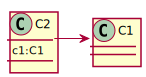

In [2]:
%%plantuml --jar
@startuml
class C1
class C2 {
    c1:C1
}
C2->C1
@enduml

### 단계 1: 컨트랙 개발

일부 0.5버전에서는 컴파일은 문제가 없었으나, 실행하면 기대하는 기능을 수행하지 못하는 증상이 있었다. 이는 이미 개발자들이 이슈에서 제기한 바, 0.4.21이하에서는 문제가 없으나 그 이후에는 문제가 있다 (https://github.com/ethereum/solidity/issues/3969).


In [32]:
%%writefile src/C1C2.sol
pragma solidity ^0.6;
//pragma solidity 0.4.21;
contract C1 {
    uint128 v1;
    function set(uint128 _v1) public {
        v1=_v1;
    }
    function get() public view returns(uint128) {
        return v1;
    }
    function get7() public pure returns(uint128) {
        return 7;
    }
}

contract C2 {
    C1 c1;
    //function C2() public {  //0.4.21 constructor
    constructor() public {    //0.6 constructor
        c1=new C1();
    }
    function set(uint128 _v1) public {
        c1.set(_v1);
    }
    function get() public view returns(uint128) {
        return c1.get();
    }
    function get7() public view returns(uint128) {
        return c1.get7();
    }
    function getC1Address() public view returns(address) {
        return address(c1);
    }
}

Overwriting src/C1C2.sol


### 단계 2: 컴파일

다음과 같이 컴파일할 수 있다.
로컬에서 설치된 solc보다 낮은 버전으로 컴파일 하려면 REMIX에서 버전을 낮추어 컴파일하고 ABI, bin을 가져온다.
파일에 컨트랙이 2개 있으면, 컴파일한 ABI, bin도 2개가 생성된다.

In [28]:
!solc src/C1C2.sol --combined-json abi,bin > src/C1C2.json

### 단계 3: 배포

컴파일 한 후, C2의 abi, bin을 가져와서 배포를 한다.

In [15]:
%%writefile src/C1C2Deploy.js
var Web3=require('web3');
var web3=new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs=require('fs');
var _str = fs.readFileSync("src/C1C2.json");
var _json=JSON.parse(_str)
//var _abiArray=JSON.parse(_json.contracts.sHello2.abi);
var _abiArray=JSON.parse(_json.contracts["src/C1C2.sol:C2"].abi);
//var _bin=_json.contracts.sHello2.bin;
var _bin="0x"+_json.contracts["src/C1C2.sol:C2"].bin;

//unlock the account with a password provided
//web3.personal.unlockAccount(web3.eth.accounts[0],'password');
async function deploy() {
    const accounts = await web3.eth.getAccounts();
    console.log("Deploying the contract from " + accounts[0]);
    var deployed = await new web3.eth.Contract(_abiArray)
        .deploy({data: _bin})
        .send({from: accounts[0], gas: 1000000})
        .on('transactionHash', function(hash){
            console.log(">>> transactionHash"+hash);
        })
        .on('receipt', function(receipt){
            console.log(">>> RECEPIT hash: " + receipt.transactionHash + "\n>>> address:" + receipt.contractAddress);
        })
        .on('error', function(error, receipt) {
            console.log(">>> ERROR "+error);
        });
        //.then(function(newContractInstance){
        //    console.log(newContractInstance.options.address)
        //});
    console.log("---> The contract deployed to: " + deployed.options.address)
}
deploy()

Overwriting src/C1C2Deploy.js


In [1]:
!node src/C1C2Deploy.js

Deploying the contract from 0xAD4c0912D2562b7072780A2F0FB2749D749B14fB
>>> transactionHash0x2188f922e7158e4b24f754886a53b1a216d7249ec4959217341acb1833cf161d
>>> RECEPIT hash: 0x2188f922e7158e4b24f754886a53b1a216d7249ec4959217341acb1833cf161d
>>> address:0x83AA5DdD047fD1B931480A6A1557F6feb54Dec8b
---> The contract deployed to: 0x83AA5DdD047fD1B931480A6A1557F6feb54Dec8b


### 단계 4: 사용

In [2]:
%%writefile src/C1C2Use.js
var Web3=require('web3');
var web3=new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs=require('fs');
var _str = fs.readFileSync("src/C1C2.json");
var _json=JSON.parse(_str)
//var _abiArray=JSON.parse(_json.contracts.sHello2.abi);
var _abiArray=JSON.parse(_json.contracts["src/C1C2.sol:C2"].abi);

var c2 = new web3.eth.Contract(_abiArray, "0x83AA5DdD047fD1B931480A6A1557F6feb54Dec8b");

async function doIt() {
    const accounts = await web3.eth.getAccounts();
    console.log("Account: " + accounts[0]);
    const balanceBefore = await web3.eth.getBalance(accounts[0]);
    console.log("Balance before: " + balanceBefore);
    c2.methods.get7().call().then(console.log);
    await c2.methods.set(9).send({from: accounts[0],gas:50000});
    c2.methods.get().call().then(console.log);
    const balanceAfter = await web3.eth.getBalance(accounts[0]);
    console.log("Balance after: " + balanceAfter);
    console.log("Balance diff: " + (balanceBefore - balanceAfter));
    //hello.methods.kill().send({from: accounts[0]})
}

doIt()


Overwriting src/C1C2Use.js


In [3]:
!node src/C1C2Use.js

Account: 0xAD4c0912D2562b7072780A2F0FB2749D749B14fB
Balance before: 99990295100000000000
7
9
Balance after: 99989414760000000000
Balance diff: 880339999997952


## 실습: 컨트랙의 주소를 사용하여 컨트랙 결합

앞서 ```new()``` 명령어는 소스코드를 포함할 수 있는 경우에 사용하였다.
이번에는 이미 배포된 컨트랙을 결합하여 보자. 그렇다면 C2에 C1의 주소를 넘겨주어야 한다. 즉 C1을 배포하고 그 주소를 알야야 한다.

### C1을 배포하고 주소를 구하기

* 단계 1: 컨트랙 개발 (C1)

In [7]:
%%writefile src/C1.sol
pragma solidity ^0.6;
//pragma solidity 0.4.21;

contract C1 {
    uint128 v1;
    function set(uint128 _v1) public {
        v1=_v1;
    }
    function get() public view returns(uint128) {
        return v1;
    }
    function get7() public pure returns(uint128) {
        return 7;
    }
}

Overwriting src/C1.sol


* 단계 2: 컴파일 (C1)

REMIX에서 0.4.21로 컴파일한 후

byzantium이 기본.
solc --evm-version "homestead" --gas C1.sol

In [8]:
!solc src/C1.sol --combined-json abi,bin > src/C1.json

In [9]:
!cat src/C1.json

{"contracts":{"src/C1.sol:C1":{"abi":"[{\"inputs\":[],\"name\":\"get\",\"outputs\":[{\"internalType\":\"uint128\",\"name\":\"\",\"type\":\"uint128\"}],\"stateMutability\":\"view\",\"type\":\"function\"},{\"inputs\":[],\"name\":\"get7\",\"outputs\":[{\"internalType\":\"uint128\",\"name\":\"\",\"type\":\"uint128\"}],\"stateMutability\":\"pure\",\"type\":\"function\"},{\"inputs\":[{\"internalType\":\"uint128\",\"name\":\"_v1\",\"type\":\"uint128\"}],\"name\":\"set\",\"outputs\":[],\"stateMutability\":\"nonpayable\",\"type\":\"function\"}]","bin":"608060405234801561001057600080fd5b506101a9806100206000396000f3fe608060405234801561001057600080fd5b50600436106100415760003560e01c8063086949b7146100465780634178462f146100885780636d4ce63c146100c8575b600080fd5b61004e61010a565b60405180826fffffffffffffffffffffffffffffffff166fffffffffffffffffffffffffffffffff16815260200191505060405180910390f35b6100c66004803603602081101561009e57600080fd5b8101908080356fffffffffffffffffffffffffffffffff1690602001909291905050

* 배포 (C1)

In [11]:
%%writefile src/C1Deploy.js
var Web3 = require('web3');
var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs=require('fs');
var _str = fs.readFileSync("src/C1.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/C1.sol:C1"].abi);
//var _bin = _json.contracts.sHello2.bin;
var _bin = "0x"+_json.contracts["src/C1.sol:C1"].bin;

//unlock the account with a password provided
//web3.personal.unlockAccount(web3.eth.accounts[0],'password');
async function deploy() {
    const accounts = await web3.eth.getAccounts();
    console.log("Deploying the contract from " + accounts[0]);
    var deployed = await new web3.eth.Contract(_abiArray)
        .deploy({data: _bin})
        .send({from: accounts[0], gas: 1000000})
        .on('transactionHash', function(hash){
            console.log(">>> transactionHash" + hash);
        })
        .on('receipt', function(receipt){
            console.log(">>> RECEPIT hash: " + receipt.transactionHash + "\n>>> address:" + receipt.contractAddress);
        })
        .on('error', function(error, receipt) {
            console.log(">>> ERROR " + error);
        });
        //.then(function(newContractInstance){
        //    console.log(newContractInstance.options.address)
        //});
    console.log("---> The contract deployed to: " + deployed.options.address)
}
deploy()


Overwriting src/C1Deploy.js


C1Deploy.js를 한 줄씩 REPL할 수 있다. Mac에서 해보니 이유없이 ```Returned error: unknown account``` 오류를 발생하고 있다.

In [12]:
!node src/C1Deploy.js

Deploying the contract from 0xAD4c0912D2562b7072780A2F0FB2749D749B14fB
>>> transactionHash0x2b3ee36d75725837b00f422b23dd5db801e8c6d39a70a60cb117b041624acbb4
>>> RECEPIT hash: 0x2b3ee36d75725837b00f422b23dd5db801e8c6d39a70a60cb117b041624acbb4
>>> address:0xc71cC556bf5C9c4694062BF4752768F65d9349Dc
---> The contract deployed to: 0xc71cC556bf5C9c4694062BF4752768F65d9349Dc


* 사용 (C1)

위 오류에도 불구하고 nodejs를 REPL로 해서 주소를 얻어서 복사해 넣고 아래를 실행하면 결과를 얻을 수 있다.

In [15]:
%%writefile src/C1Use.js
var Web3=require('web3');
var web3=new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs=require('fs');
var _str = fs.readFileSync("src/C1.json");
var _json=JSON.parse(_str)
//var _abiArray=JSON.parse(_json.contracts.sHello2.abi);
var _abiArray=JSON.parse(_json.contracts["src/C1.sol:C1"].abi);

var c1 = new web3.eth.Contract(_abiArray, "0xc71cC556bf5C9c4694062BF4752768F65d9349Dc");
async function doIt() {
    const accounts = await web3.eth.getAccounts();
    console.log("Account: " + accounts[0]);
    const balanceBefore = await web3.eth.getBalance(accounts[0]);
    console.log("Balance before: " + balanceBefore);
    c1.methods.get7().call().then(console.log);
    await c1.methods.set(9).send({from: accounts[0],gas:50000});
    c1.methods.get().call().then(console.log);
    const balanceAfter = await web3.eth.getBalance(accounts[0]);
    console.log("Balance after: " + balanceAfter);
    console.log("Balance diff: " + (balanceBefore - balanceAfter));
    //hello.methods.kill().send({from: accounts[0]})
}

doIt()


Overwriting src/C1Use.js


In [16]:
!node src/C1Use.js

Account: 0xAD4c0912D2562b7072780A2F0FB2749D749B14fB
Balance before: 99986065100000000000
7
9
Balance after: 99985225800000000000
Balance diff: 839300000006144


### 단계 1: 컨트랙 개발 (C2)

```C1```과 ```C2```를 결합하는 소스코드를 구현해보자.
```C1```은 이미 배포가 되었고, 그 주소를 받을 수 있는 기능이 필요하다.
이 경우 ```C1```의 abi를 모르면 ```C2```를 컴파일을 할 수 없다.
예를 들어 ```C1```의 함수 ```c1.get7()```를 모르면, C2의 ```get7()```을 컴파일 할 수 없게 된다.

앞서 ```C1.sol```, ```C2.sol```을 한 파일 안에 적어주지 않고,
```import```문으로 ```C1```을 포함한다.
이 경우 ```import C1.sol```이라고 해주지 않고, 현재 파일의 상대 디렉토리 ```import "./C1.sol"```로 적어준다.

구분 | 사용 예 | 이유
-----|-----|-----
올바른 사용 | ```import "./C1.sol"``` | 상대 디렉토리로 적어주면 ```C1.sol```을 못 찾는다.
올바르지 않은 사용 | ```import "C1.sol"``` | 상대 디렉토리가 아니라서 오류가 발생

In [17]:
%%writefile src/C2.sol
pragma solidity 0.6;
//pragma solidity 0.4.21;
import "./C1.sol";

contract C2 {
    C1 c1;
    //function C2() public {  //0.4.21 constructor
    constructor() public {    //0.6 constructor
        c1=new C1();
    }
    function setC1(address _addressOfC1) public {
        c1 = C1(_addressOfC1);
    }
    function set(uint128 _v1) public {
        c1.set(_v1);
    }
    function get() public view returns(uint128) {
        return c1.get();
    }
    function get7() public view returns(uint128) {
        return c1.get7();
    }
    function getC1Address() public view returns(address) {
        return address(c1);
    }
}

Overwriting src/C2.sol


### 단계 2: 컴파일 (C2)

C2를 컴파일한다.

In [18]:
!solc src/C2.sol --combined-json abi,bin > src/C2.json

### 단계 3: 배포

In [20]:
%%writefile src/C2Deploy.js
var Web3 = require('web3');
var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs=require('fs');
var _str = fs.readFileSync("src/C2.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/C2.sol:C2"].abi);
//var _bin = _json.contracts.sHello2.bin;
var _bin = "0x"+_json.contracts["src/C2.sol:C2"].bin;

//unlock the account with a password provided
//web3.personal.unlockAccount(web3.eth.accounts[0],'password');
async function deploy() {
    const accounts = await web3.eth.getAccounts();
    console.log("Deploying the contract from " + accounts[0]);
    var deployed = await new web3.eth.Contract(_abiArray)
        .deploy({data: _bin})
        .send({from: accounts[0], gas: 1000000})
        .on('transactionHash', function(hash){
            console.log(">>> transactionHash" + hash);
        })
        .on('receipt', function(receipt){
            console.log(">>> RECEPIT hash: " + receipt.transactionHash + "\n>>> address:" + receipt.contractAddress);
        })
        .on('error', function(error, receipt) {
            console.log(">>> ERROR " + error);
        });
        //.then(function(newContractInstance){
        //    console.log(newContractInstance.options.address)
        //});
    console.log("---> The contract deployed to: " + deployed.options.address)
}
deploy()


Overwriting src/C2Deploy.js


In [46]:
!node src/C2Deploy.js

Deploying the contract from 0xAD4c0912D2562b7072780A2F0FB2749D749B14fB
>>> transactionHash0xa590fbd70cb5e86b8d80c25212ce83891136d2c4a40aff8952a9916cf81fd049
>>> RECEPIT hash: 0xa590fbd70cb5e86b8d80c25212ce83891136d2c4a40aff8952a9916cf81fd049
>>> address:0xe812078c783942dA662E89acF3351d0Fbf16cF81
---> The contract deployed to: 0xe812078c783942dA662E89acF3351d0Fbf16cF81


### 단계 4: 사용

줄 | 함수 | 설명
-----|-----|-----
16 | ```c2.methods.getC1Address().call()``` | 생성자에서 ```new``` 명령어로 생성된 ```C1```의 주소를 출력. 단, ```C2```를 배포하고 첫 회 실행할 때만 유효하고, 2회부터는 이전에 실행된 ```setC1()```의 결과인 이전 ```C1```의 주소가 출력된다.
19 | ```c2.methods.get7().call()``` | ```await```로 하지 않으면 실행 순서가 늦춰질 수 있다.
21 | c2.methods.setC1() | 생성자에서 설정한 C1을 제거하고, 위에서 블록체인에 배포한 C1의 주소를 사용하여 교체한다.

In [47]:
%%writefile src/C2Use.js
var Web3=require('web3');
var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs=require('fs');
var _str = fs.readFileSync("src/C2.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/C2.sol:C2"].abi);

var c2 = new web3.eth.Contract(_abiArray, "0xe812078c783942dA662E89acF3351d0Fbf16cF81");
async function doIt() {
    const accounts = await web3.eth.getAccounts();
    console.log("Account: " + accounts[0]);
    const balanceBefore = await web3.eth.getBalance(accounts[0]);
    console.log("Balance before: " + balanceBefore);
    console.log("--- new C1 ---");
    await c2.methods.getC1Address().call(function(err, c1addr) {
        if(!err) console.log("c1 address by 'new': "+c1addr);
    });
    await c2.methods.get7().call().then(console.log);
    console.log("--- set the above deployed address of C1 ---");
    await c2.methods.setC1("0xc71cC556bf5C9c4694062BF4752768F65d9349Dc").send({from:accounts[0], gas:50000});
    await c2.methods.getC1Address().call(function(err, c1addr) {
        if(!err) console.log("c1 address by 'setC1()': "+c1addr);
    });
    c2.methods.get7().call().then(console.log);
    await c2.methods.set(222).send({from: accounts[0],gas:50000});
    c2.methods.get().call().then(console.log);
    const balanceAfter = await web3.eth.getBalance(accounts[0]);
    console.log("Balance after: " + balanceAfter);
    console.log("Balance diff: " + (balanceBefore - balanceAfter));
    //hello.methods.kill().send({from: accounts[0]})
}

doIt()


Overwriting src/C2Use.js


In [48]:
!node src/C2Use.js

Account: 0xAD4c0912D2562b7072780A2F0FB2749D749B14fB
Balance before: 99945866560000000000
--- new C1 ---
c1 address by 'new': 0x6BA98F59D5E3dDd9a3A38727e04dFDC4C4bE9D16
7
--- set the above deployed address of C1 ---
c1 address by 'setC1()': 0xc71cC556bf5C9c4694062BF4752768F65d9349Dc
7
222
Balance after: 99944817720000000000
Balance diff: 1048839999995904


2회를 실행하면 아래에서 보는 것처럼 C1의 주소가 같아진다.
2회부터는 이전에 실행된 ```setC1()```의 결과인 이전 ```C1```의 주소로 설정되어 출력된다.
생성자가 최초에만 호출되기 때문이다.

다시 생성자를 호출하여 ```C1```의 주소를 설정하려면, C2를 다시 배포한 후 그 주소로 ```C2Use.js```를 실행하면 된다.

In [49]:
!node src/C2Use.js

Account: 0xAD4c0912D2562b7072780A2F0FB2749D749B14fB
Balance before: 99944817720000000000
--- new C1 ---
c1 address by 'new': 0xc71cC556bf5C9c4694062BF4752768F65d9349Dc
7
--- set the above deployed address of C1 ---
c1 address by 'setC1()': 0xc71cC556bf5C9c4694062BF4752768F65d9349Dc
7
222
Balance after: 99943864880000000000
Balance diff: 952839999995904


## 실습: 자동차와 엔진 컨트랙: new 명령어 사용

동일한 파일에 2개의 컨트랙을 넣어서 개발해 보자.

### 단계 1: 컨트랙 개발

Line | 설명
-----|-----
1 | major version 6 이상 최신으로 컴파일
2 | contract 명. 컨트랙이 2개 포함된 경우, 파일명과 반드시 일치할 필요가 없다.
4 | ```Engine```을 포함하고, ```constructor```에서 할당한다.
26 ~ 31 | ```start()```은 ```engineObj.on()``` 엔진을 켠다. 그리고 엔진상태를 이벤트로 발생한다.
52 ~ 60 | ```speed```가 0 ~ 최대속도 범위 내에서 속도를 증감하도록 한다. 감속을 위해 음수를 사용할 수 있도록 ```int```를 적용하면 ```uint```로 형변환이 필요함.

In [15]:
%%writefile src/Car.sol
pragma solidity ^0.6.0;
//pragma solidity 0.4.21;
contract Car {
    Engine engineObj;
    string private color;
    event PrintLog(address sender, string msg);

    constructor() public {
        engineObj = new Engine();
    }
    function setColor(string memory _color) public {
        color=_color;
    }
    function getColor() public view returns(string memory) {
        return color;
    }
    function getSpeed() public view returns(uint) {
        return engineObj.getSpeed();
    }
    function speedUpBy10() public {
        engineObj.setSpeedUpBy(10);
    }
    function speedDownBy10() public {
        engineObj.setSpeedDownBy(10);   
    }
    function start() public {
        engineObj.on();
        //convert bool to string
        string memory engineStateStr=engineObj.getEngineState()? "on" : "off";
        emit PrintLog(msg.sender, engineStateStr);
    }
}

contract Engine {
    uint constant private MAXSPEED = 200;
    uint private speed;
    bool private engineState;

    constructor() public {
        speed = 0;
        off();
    }
    function on() public {
        engineState = true;
    }
    function off() public {
        engineState = false;
    }
    function getEngineState() public view returns(bool){
        return engineState;
    }
    function setSpeedUpBy(uint _speed) public {
        if(speed < (MAXSPEED - 10) && engineState == true)
            speed += _speed;
    }
    // int _speed -> needs casting to uint (speed)
    function setSpeedDownBy(uint _speed) public {
        if((speed - 10) > 0  && engineState == true)
            speed -= _speed;
    }
    function getSpeed() public view returns(uint) {
        return speed;
    }
}

Overwriting src/Car.sol


### 단계 2: 컴파일

현재 설치되어 있는 버전 0.6으로 컴파일 해서, abi, bin을 구한다.
버전이 다른 경우, REMIX에서 컴파일한다.

In [16]:
!solc src/Car.sol --combined-json abi,bin > src/Car.json

### 단계 3: 배포

In [1]:
%%writefile src/carDeploy.js
var Web3=require('web3');
var web3=new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs=require('fs');
var _str = fs.readFileSync("src/Car.json");
var _json=JSON.parse(_str)
//var _abiArray=JSON.parse(_json.contracts.sHello2.abi);
var _abiArray=JSON.parse(_json.contracts["src/Car.sol:Car"].abi);
//var _bin=_json.contracts.sHello2.bin;
var _bin="0x"+_json.contracts["src/Car.sol:Car"].bin;

//unlock the account with a password provided
//web3.personal.unlockAccount(web3.eth.accounts[0],'password');
async function deploy() {
    const accounts = await web3.eth.getAccounts();
    console.log("Deploying the contract from " + accounts[0]);
    var deployed = await new web3.eth.Contract(_abiArray)
        .deploy({data: _bin})
        .send({from: accounts[0], gas: 1000000})
        .on('transactionHash', function(hash){
            console.log(">>> transactionHash"+hash);
        })
        .on('receipt', function(receipt){
            console.log(">>> RECEPIT hash: " + receipt.transactionHash + "\n>>> address:" + receipt.contractAddress);
        })
        .on('error', function(error, receipt) {
            console.log(">>> ERROR "+error);
        });
        //.then(function(newContractInstance){
        //    console.log(newContractInstance.options.address)
        //});
    console.log("---> The contract deployed to: " + deployed.options.address)
}
deploy()


Overwriting src/carDeploy.js


In [2]:
!node src/carDeploy.js

Deploying the contract from 0x6DbfE74e38B1157F5AFA5F9122AD9C56671Fc50E
>>> transactionHash0xf23a81b3f842ebbf385065f238dae116b768ba48c7d8e2b3c87b428ea48ef814
>>> RECEPIT hash: 0xf23a81b3f842ebbf385065f238dae116b768ba48c7d8e2b3c87b428ea48ef814
>>> address:0xd47b1A1c9D52730F6D8c44247241f3CC2786B9E9
---> The contract deployed to: 0xd47b1A1c9D52730F6D8c44247241f3CC2786B9E9


### 단계 4: 사용
아래를 실행하면 다음 결과

```python
> car.getColor.call();
'RED'
```

In [1]:
%%writefile src/carUse.js
var Web3=require('web3');
//var web3=new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));         //nok
//var web3 = new Web3(new Web3.providers.WebsocketProvider("http://117.16.44.45:8345"));  //ok
var web3 = new Web3(new Web3.providers.WebsocketProvider("ws://117.16.44.45:8345"));
var fs=require('fs');
var _str = fs.readFileSync("src/Car.json");
var _json=JSON.parse(_str)
//var _abiArray=JSON.parse(_json.contracts.sHello2.abi);
var _abiArray=JSON.parse(_json.contracts["src/Car.sol:Car"].abi);

async function doIt() {
    var car = new web3.eth.Contract(_abiArray, "0xd47b1A1c9D52730F6D8c44247241f3CC2786B9E9");
    car.events.PrintLog({fromBlock: 'latest', toBlock:'pending'}, function (error, event) {
            console.log(">>> Event fired: " + JSON.stringify(event.returnValues));
        }).on('>> data', function(event){
            console.log(event); // same results as the optional callback above
        }).on('>> changed', function(event){
            console.log(event); // remove event from local database
        }).on('>> error', console.error);

    var speed;
    const accounts = await web3.eth.getAccounts();
    console.log("Account: " + accounts[0]);
    const balanceBefore = await web3.eth.getBalance(accounts[0]);
    console.log("Balance before: " + balanceBefore);
    car.methods.setColor("RED").send({from: accounts[0], gas:100000});
    car.methods.getColor().call().then(console.log);
    await car.methods.start().send({from: accounts[0], gas:100000})
    await car.methods.speedUpBy10().send({from: accounts[0], gas:100000})
    car.methods.getSpeed().call().then(function(speed) { console.log("-> speed: " + speed) });
    await car.methods.start().send({from: accounts[0], gas:100000})
    await car.methods.speedUpBy10().send({from: accounts[0], gas:100000})
    car.methods.getSpeed().call().then(function(speed) { console.log("-> speed: " + speed) });
    await car.methods.speedDownBy10().send({from: accounts[0], gas:100000})
    car.methods.getSpeed().call().then(function(speed) { console.log("-> speed: " + speed) });
    const balanceAfter = await web3.eth.getBalance(accounts[0]);
    console.log("Balance after: " + balanceAfter);
    console.log("Balance diff: " + (balanceBefore - balanceAfter));
}

doIt()


Overwriting src/carUse.js


In [ ]:
!node src/carUse.js

Account: 0x6DbfE74e38B1157F5AFA5F9122AD9C56671Fc50E
Balance before: 99956307280000000000
RED
>>> Event fired: {"0":"0x6DbfE74e38B1157F5AFA5F9122AD9C56671Fc50E","1":"on","sender":"0x6DbfE74e38B1157F5AFA5F9122AD9C56671Fc50E","msg":"on"}
-> speed: 90
>>> Event fired: {"0":"0x6DbfE74e38B1157F5AFA5F9122AD9C56671Fc50E","1":"on","sender":"0x6DbfE74e38B1157F5AFA5F9122AD9C56671Fc50E","msg":"on"}
-> speed: 100
-> speed: 90
Balance after: 99952940540000000000
Balance diff: 3366739999997952


## 실습: 사각형과 면적 컨트랙: new 명령어 사용

SquareArea passing address

### 단계 1: 컨트랙 개발

In [1]:
%%writefile src/SquareArea.sol
pragma solidity ^0.6.0;
//pragma solidity 0.4.21;

contract Square {
    uint128 length;
    function getLength() public view returns(uint128) {
        return length;
    }
    function setLength(uint128 _length) public {
        length=_length;
    }
    function getDegree() public pure returns(uint128) {
        return 90;
    }
}

contract Area {
    Square s;
    address owner;
    //event PrintLog(uint128);
    //function Area() public {
    constructor() public {
        s = new Square();
        owner = msg.sender;
    }
    function changeSquare(address _addressOfSquare) public {
        s=Square(_addressOfSquare);
    }
    function calcArea() view public returns(uint128) {
        uint128 length = s.getLength();
        uint128 area = length*length;
        //emit PrintLog(area);
        return area;
    }
    function setLength(uint128 _length) public {
        s.setLength(_length);
    }
    function getLength() public view returns(uint128) {
        return s.getLength();
    }
    function getDegree() public view returns(uint128) {
        return s.getDegree();
    }
    function getAddressOfSquare() public view returns(address) {
        return address(s);
    }
}


Overwriting src/SquareArea.sol


### 단계 2: 컴파일


In [2]:
!solc src/SquareArea.sol --combined-json abi,bin > src/SquareArea.json

### 단계 3: 컨트랙 배포

In [10]:
%%writefile src/SquareAreaDeploy.js
var Web3 = require('web3');
var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs=require('fs');
var _str = fs.readFileSync("src/SquareArea.json");
var _json=JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/SquareArea.sol:Area"].abi);
//var _bin = _json.contracts.sHello2.bin;
var _bin = "0x" + _json.contracts["src/SquareArea.sol:Area"].bin;

//unlock the account with a password provided
//web3.personal.unlockAccount(web3.eth.accounts[0],'password');
async function deploy() {
    const accounts = await web3.eth.getAccounts();
    console.log("Deploying the contract from " + accounts[0]);
    var deployed = await new web3.eth.Contract(_abiArray)
        .deploy({data: _bin})
        .send({from: accounts[0], gas: 1000000})
        .on('transactionHash', function(hash){
            console.log(">>> transactionHash"+hash);
        })
        .on('receipt', function(receipt){
            console.log(">>> RECEPIT hash: " + receipt.transactionHash + "\n>>> address:" + receipt.contractAddress);
        })
        .on('error', function(error, receipt) {
            console.log(">>> ERROR "+error);
        });
        //.then(function(newContractInstance){
        //    console.log(newContractInstance.options.address)
        //});
    console.log("---> The contract deployed to: " + deployed.options.address)
}

deploy()


Overwriting src/SquareAreaDeploy.js


In [11]:
!node src/SquareAreaDeploy.js

Deploying the contract from 0x0A2aca05EB30707F09C883A4b1881F775ACA4Fa8
>>> transactionHash0xd5a4bd2033ddf42c43703f09687ac7475def381779ba5e976a17eca6e55743d4
>>> RECEPIT hash: 0xd5a4bd2033ddf42c43703f09687ac7475def381779ba5e976a17eca6e55743d4
>>> address:0x99c9e13Fb74Ec1B86Df5712CDF382757788C235C
---> The contract deployed to: 0x99c9e13Fb74Ec1B86Df5712CDF382757788C235C


### 단계 4: 사용

In [ ]:
```python
> area.methods.getDegree().call().then(console.log);
> 90
> area.methods.setLength(9).send({from:"0x9cd639aac746b3bbc85e386c05cf1ac74925112e"});
> //miner.start(1);admin.sleepBlocks(1);miner.stop();
undefined
> area.methods.getLength().call().then(console.log);
> 9
> area.methods.calcArea().send({from:"0x9cd639aac746b3bbc85e386c05cf1ac74925112e"});
> //miner.start(1);admin.sleepBlocks(1);miner.stop();
undefined
> area.methods.calcArea().call().then(console.log);           로컬에서 처리되기 때문에 이전 면적계산 값 81을 반환
> 81
> area.methods.getAddressOfSquare().call().then(console.log);
> 0x9f75D1A80D5715EED0962dd72d1d4E409DaCF037
```

처음 실행하면 길이는 0이다. 그 다음 실행하면 9가 된다. 그 이유는 asynch방식이라 마이닝하지 않고 연달아 시행하면 마이닝 전의 결과가 나오기 때문에 그렇다.

In [12]:
%%writefile src/SquareAreaUse.js
var Web3 = require('web3');
//var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));         //nok
//var web3 = new Web3(new Web3.providers.WebsocketProvider("http://117.16.44.45:8345"));  //ok
var web3 = new Web3(new Web3.providers.WebsocketProvider("ws://117.16.44.45:8345"));
var fs=require('fs');
var _str = fs.readFileSync("src/SquareArea.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/SquareArea.sol:Area"].abi);

async function doIt() {
    var area = new web3.eth.Contract(_abiArray, "0x99c9e13Fb74Ec1B86Df5712CDF382757788C235C");
    var speed;
    const accounts = await web3.eth.getAccounts();
    console.log("Account: " + accounts[0]);
    const balanceBefore = await web3.eth.getBalance(accounts[0]);
    console.log("Balance before: " + balanceBefore);
    area.methods.getDegree().call().then(console.log);
    await area.methods.setLength(9).send({from: accounts[0]});
    area.methods.getLength().call().then(console.log);
    //area.methods.calcArea().send({from: accounts[0]});
    area.methods.calcArea().call().then(console.log);
    area.methods.getAddressOfSquare().call().then(function(address) {
        console.log("Square Address: " + address);
    });
    const balanceAfter = await web3.eth.getBalance(accounts[0]);
    console.log("Balance after: " + balanceAfter);
    console.log("Balance diff: " + (balanceBefore - balanceAfter));
}

doIt()


Overwriting src/SquareAreaUse.js


아래에서 구한 ```Square```의 주소는 다음 문제에서 ```changeSquare(address _addressOfSquare)```에 설정하여 사용해보자.

In [ ]:
!node src/SquareAreaUse.js

Account: 0x0A2aca05EB30707F09C883A4b1881F775ACA4Fa8
Balance before: 99973924640000000000
90
9
81
Square Address: 0x748929714418AaF173Cc14cB269BA246573a71eD
Balance after: 99973043860000000000
Balance diff: 880780000002048


## 실습: import 문을 사용하여 컨트랙 결합

import문을 사용하여 Square.sol과 이를 사용하는 Area.sol을 


### 단계 1: 컨트랙 개발

#### Square

```Square.sol```은 별도로 로컬 파일에 저장해서, ```Area.sol```에서 포함하도록 한다.
```Square.sol```은 컴파일하지 않는다.

In [1]:
%%writefile src/Square.sol
pragma solidity ^0.6.0;
//pragma solidity 0.4.21;

contract Square {
    uint128 length;
    function getLength() public view returns(uint128) {
        return length;
    }
    function setLength(uint128 _length) public {
        length=_length;
    }
    function getDegree() public pure returns(uint128) {
        return 90;
    }
}

Overwriting src/Square.sol


#### Area

Square를 import할 때는 컴파일하는 Area.sol 기준으로 상대 경로 ```import "./Square.sol"```로 적어준다.

In [2]:
%%writefile src/Area.sol
pragma solidity ^0.6.0;
//pragma solidity 0.4.21;

import "./Square.sol";

contract Area {
    Square s;
    address owner;
    //event PrintLog(uint128);
    //function Area() public {  //0.4.21
    constructor() public {
        s = new Square();
        owner = msg.sender;
    }
    function changeSquare(address _addressOfSquare) public {
        s=Square(_addressOfSquare);
    }
    function calcArea() view public returns(uint128) {
        uint128 length = s.getLength();
        uint128 area = length*length;
        //emit PrintLog(area);
        return area;
    }
    function setLength(uint128 _length) public {
        s.setLength(_length);
    }
    function getLength() public view returns(uint128) {
        return s.getLength();
    }
    function getDegree() public view returns(uint128) {
        return s.getDegree();
    }
    function getAddressOfSquare() public view returns(address) {
        return address(s);
    }
}

Overwriting src/Area.sol


### 단계 2: 컴파일

import 문으로 포함했으니, Square를 컴파일해서, abi, bin를 필요하지 않는다.

In [3]:
!solc src/Area.sol --combined-json abi,bin > src/Area.json

### 단계 3: 컨트랙 배포

컴파일하고 Area.sol의 abi, bin만을 넣어준다. Square.sol의 abi,bin은 무시한다.

In [1]:
%%writefile src/AreaDeploy.js
var Web3 = require('web3');
var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs = require('fs');
var _str = fs.readFileSync("src/Area.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/Area.sol:Area"].abi);
//var _bin = _json.contracts.sHello2.bin;
var _bin = "0x" + _json.contracts["src/Area.sol:Area"].bin;

//unlock the account with a password provided
//web3.personal.unlockAccount(web3.eth.accounts[0],'password');
async function deploy() {
    const accounts = await web3.eth.getAccounts();
    console.log("Deploying the contract from " + accounts[0]);
    var deployed = await new web3.eth.Contract(_abiArray)
        .deploy({data: _bin})
        .send({from: accounts[0], gas: 1000000}, function(err, transactionHash) {
            if(!err) console.log("hash: " + transactionHash); 
        })
        //.then(function(newContractInstance){
        //    console.log(newContractInstance.options.address)
        //});
    console.log("---> The contract deployed to: " + deployed.options.address)
}

deploy()


Overwriting src/AreaDeploy.js


In [15]:
!node src/AreaDeploy.js

Deploying the contract from 0x0A2aca05EB30707F09C883A4b1881F775ACA4Fa8
hash: 0x5f65d6f449e7d85fb4c1550e91385207eb4849af92c079ff3084932ee51dfbec
---> The contract deployed to: 0x0b7bF4eaD0Ac5e4f8a301852F626fEeccA07b8c6


### 단계 4: 사용

함수 | 설명
-----|-----
```getAddressOfSquare()``` | 생성자에서 할당된 Square 주소, 즉 ```import ./Square.sol```에서 가져온 ```new Square()```의 주소. 주소 없이 ```new Square()```라고 해도 문제없이 실행이 된다. 즉, ```import```문을 사용하면 주소없이 컨트랙을 생성해서 사용할 수 있다는 의미이다.
```setLength()``` | 길이 설정하고
```calcArea()``` | 설정된 길이로 면적을 계산
```changeSquare('0x748929714418AaF173Cc14cB269BA246573a71eD')``` | 주소를 재설정. 위에서 주소를 넣는다. 즉, 앞서 ```SquareArea.sol```을 컴파일하고 ```getAddressOfSquare()```에서 구한 ```Square```의 주소를 넣어 ```Square```를 교체하여 보자.  단 주소에 따옴표를 해야 한다. 그러고 나서 기능이 적절히 수행되는지 확인해 보자.

In [16]:
%%writefile src/AreaUse.js
var Web3=require('web3');
var web3=new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));       //nok
//var web3 = new Web3(new Web3.providers.WebsocketProvider("http://117.16.44.45:8345"));  //ok
//var web3 = new Web3(new Web3.providers.WebsocketProvider("ws://117.16.44.45:8345"));  //ok
var fs=require('fs');
var _str = fs.readFileSync("src/Area.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.Area.abi);
var _abiArray = JSON.parse(_json.contracts["src/Area.sol:Area"].abi);

async function doIt() {
    var hello = new web3.eth.Contract(_abiArray, "0x0b7bF4eaD0Ac5e4f8a301852F626fEeccA07b8c6");
    const accounts = await web3.eth.getAccounts();
    console.log("Account: " + accounts[0]);
    const balanceBefore = await web3.eth.getBalance(accounts[0]);
    console.log("Balance before: " + balanceBefore);
    // do by the Square address as set in the constructor
    hello.methods.getAddressOfSquare().call(function(err, c1addr) {
        if(!err) console.log(">> Square address by 'new': "+c1addr);
    });
    await hello.methods.setLength(10).send({from: accounts[0]});
    hello.methods.getLength().call().then(console.log);
    hello.methods.calcArea().call().then(console.log);
    hello.methods.getDegree().call().then(console.log);
    hello.methods.getAddressOfSquare().call().then(console.log);
    //redo by the Square address as changed by changeSquare()
    await hello.methods.changeSquare('0x748929714418AaF173Cc14cB269BA246573a71eD').send({from: accounts[0]});
    hello.methods.getAddressOfSquare().call(function(err, c1addr) {
        if(!err) console.log(">> Square address by 'changeSquare: "+c1addr);
    });
    await hello.methods.setLength(10).send({from: accounts[0]});
    hello.methods.getLength().call().then(console.log);
    hello.methods.calcArea().call().then(console.log);
    hello.methods.getDegree().call().then(console.log);
    hello.methods.getAddressOfSquare().call().then(console.log);
    const balanceAfter = await web3.eth.getBalance(accounts[0]);
    console.log("Balance after: " + balanceAfter);
    console.log("Balance diff: " + (balanceBefore - balanceAfter));
}

doIt()


Overwriting src/AreaUse.js


In [17]:
!node src/AreaUse.js

Account: 0x0A2aca05EB30707F09C883A4b1881F775ACA4Fa8
Balance before: 99954709760000000000
>> Square address by 'new': 0x07cE6901B343abA0Fabe1098E360F7503De920cD
10
100
90
0x07cE6901B343abA0Fabe1098E360F7503De920cD
>> Square address by 'changeSquare: 0x748929714418AaF173Cc14cB269BA246573a71eD
10
100
90
0x748929714418AaF173Cc14cB269BA246573a71eD
Balance after: 99952778820000000000
Balance diff: 1930939999993856


2회 실행하면 생성자는 최초에만 실행되므로, ```Square```의 주소가 변경된 상태로 실행된다.

In [18]:
!node src/AreaUse.js

Account: 0x0A2aca05EB30707F09C883A4b1881F775ACA4Fa8
Balance before: 99952778820000000000
>> Square address by 'new': 0x748929714418AaF173Cc14cB269BA246573a71eD
10
100
90
0x748929714418AaF173Cc14cB269BA246573a71eD
>> Square address by 'changeSquare: 0x748929714418AaF173Cc14cB269BA246573a71eD
10
100
90
0x748929714418AaF173Cc14cB269BA246573a71eD
Balance after: 99951339880000000000
Balance diff: 1438940000010240


###  registrar

```python
> primary = eth.accounts[0];
'0xa5cd6f89bb6100aa6c1f634fa5937f0b201ff43c'
> globalRegistrarAddr = admin.setGlobalRegistrar("", primary);
Please unlock account a5cd6f89bb6100aa6c1f634fa5937f0b201ff43c.
Passphrase: 
Account is now unlocked for this session.
'0x89101a18ba7d97c35bcff99e8f2d290ecd9e9faabc8b4b36200b237d9974545d'
> globalRegistrarAddr
'0x89101a18ba7d97c35bcff99e8f2d290ecd9e9faabc8b4b36200b237d9974545d'
>
```

## 12.3 상속
<a id='S.8'></a>

* 상속
    * abstract contract

### 단계 1: 컨트랙 개발

In [1]:
%%writefile src/Point.sol
pragma solidity ^0.6.0;
contract Point {
    int x;
    int y;
    constructor(int _x, int _y) public {
        x = _x;
        y = _y;
    }
    function getX() view public returns(int) { return x; }
    function getY() view  public returns(int) { return y; }
}

Writing src/Point.sol


In [6]:
%%writefile src/Rectangle.sol
pragma solidity ^0.6.0;
import "./Point.sol";

contract Rectangle is Point {
    int w;
    int h;
    constructor(int _w, int _h, int _x, int _y) Point(_x, _y) public {
        //super(_x, _y); //nok
        w = _w;  //this.x --> nok
        h = _h;
    }
    function getPerimeter() view public returns(int) {
        return 2*(w+h);
    }
    function getXOpposite() view public returns(int) { return getX() + w; }
    function getYOpposite() view public returns(int) { return getY() + h; }
}

Overwriting src/Rectangle.sol


### 단계 2: 컴파일

In [7]:
!solc src/Rectangle.sol --combined-json abi,bin > src/Rectangle.json

### 단계 3: 컨트랙 배포

배포할 경우 superclass는 이미 포함되므로 greeter abi, bin만 넣어서 배포한다.
constrcutor가 문자열을 인자로 받으므로 4개의 인자를 넣어준다.

In [18]:
%%writefile src/RectangleDeploy.js
var Web3 = require('web3');
var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs = require('fs');
var _str = fs.readFileSync("src/Rectangle.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/Rectangle.sol:Rectangle"].abi);
//var _bin = _json.contracts.sHello2.bin;
var _bin = "0x" + _json.contracts["src/Rectangle.sol:Rectangle"].bin;

//unlock the account with a password provided
//web3.personal.unlockAccount(web3.eth.accounts[0],'password');
async function deploy() {
    const accounts = await web3.eth.getAccounts();
    console.log("Deploying the contract from " + accounts[0]);
    var deployed = await new web3.eth.Contract(_abiArray)
        .deploy({data: _bin, arguments: [10, 20, 30, 40]})
        .send({from: accounts[0], gas: 1000000}, function(err, transactionHash) {
                if(!err) console.log("hash: " + transactionHash); 
        })
        //.then(function(newContractInstance){
        //    console.log(newContractInstance.options.address)
        //});
    console.log("---> The contract deployed to: " + deployed.options.address)
}

deploy()


Overwriting src/RectangleDeploy.js


In [19]:
!node src/RectangleDeploy.js

Deploying the contract from 0x835e0FBEda65c1208bFc37282bfE723d2412c152
hash: 0xee621084021916ddd6591d0db98c8f2e091d69220c93b6117508b0df4d1a57fc
---> The contract deployed to: 0x86d0672dd21b18BAD38b4d7Cb9A47BdDFaeB9c10


### 단계 4: 사용

In [21]:
%%writefile src/RectangleUse.js
var Web3=require('web3');
var web3=new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));       //nok
//var web3 = new Web3(new Web3.providers.WebsocketProvider("http://117.16.44.45:8345"));  //ok
//var web3 = new Web3(new Web3.providers.WebsocketProvider("ws://117.16.44.45:8345"));  //ok
var fs = require('fs');
var _str = fs.readFileSync("src/Rectangle.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/Rectangle.sol:Rectangle"].abi);

async function doIt() {
    var hello = new web3.eth.Contract(_abiArray, "0x86d0672dd21b18BAD38b4d7Cb9A47BdDFaeB9c10");
    const accounts = await web3.eth.getAccounts();
    console.log("Account: " + accounts[0]);
    const balanceBefore = await web3.eth.getBalance(accounts[0]);
    console.log("Balance before: " + balanceBefore);
    hello.methods.getPerimeter().call().then(console.log);
    hello.methods.getXOpposite().call().then(console.log);
    hello.methods.getYOpposite().call().then(console.log);
    const balanceAfter = await web3.eth.getBalance(accounts[0]);
    console.log("Balance after: " + balanceAfter);
    console.log("Balance diff: " + (balanceBefore - balanceAfter));
    
}

doIt()


Writing src/RectangleUse.js


너비는 2 * (10 + 20), XOpposite는 30 + 10, YOpposite는 40 + 20

In [22]:
!node src/RectangleUse.js

Account: 0x835e0FBEda65c1208bFc37282bfE723d2412c152
Balance before: 99995171720000000000
60
40
60
Balance after: 99995171720000000000
Balance diff: 0


## 실습: greeter.sol

* 출처 https://www.ethereum.org/greeter
* 복수 contract을 컴파일하고, 서로 참조하는 경우

### 단계 1: 컨트랙 개발

Solidity 0.5.0부터 address and address payable로 타잎이 구분되었다.
selfdestruct는 컨트랙을 삭제하는 경우, 잔액을 반환하는 주소.

In [20]:
%%writefile src/greeter.sol
pragma solidity ^0.5.0;
contract mortal {
    /* Define variable owner of the type address*/
    address payable owner;

    /* this function is executed at initialization and sets the owner of the contract */
    constructor() public { owner = msg.sender; }

    /* Function to recover the funds on the contract */
    function kill() public { if (msg.sender == owner) selfdestruct(owner); }
}

contract greeter is mortal {
    /* define variable greeting of the type string */
    string greeting;

    /* this runs when the contract is executed */
    constructor(string memory _greeting) public {
        greeting = _greeting;
    }

    /* main function */
    function greet() public view returns (string memory) {
        return greeting;
    }
}

Overwriting src/greeter.sol


### 단계 3: 컨트랙 배포

In [19]:
%%writefile src/greeterDeploy.js
var Web3=require('web3');
var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var _abiArray=[{"constant":false,"inputs":[],"name":"kill","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"greet","outputs":[{"name":"","type":"string"}],"payable":false,"stateMutability":"view","type":"function"},{"inputs":[{"name":"_greeting","type":"string"}],"payable":false,"stateMutability":"nonpayable","type":"constructor"}];
var _bin="0x"+"608060405234801561001057600080fd5b506040516103db3803806103db8339810180604052602081101561003357600080fd5b81019080805164010000000081111561004b57600080fd5b8281019050602081018481111561006157600080fd5b815185600182028301116401000000008211171561007e57600080fd5b5050929190505050336000806101000a81548173ffffffffffffffffffffffffffffffffffffffff021916908373ffffffffffffffffffffffffffffffffffffffff16021790555080600190805190602001906100dc9291906100e3565b5050610188565b828054600181600116156101000203166002900490600052602060002090601f016020900481019282601f1061012457805160ff1916838001178555610152565b82800160010185558215610152579182015b82811115610151578251825591602001919060010190610136565b5b50905061015f9190610163565b5090565b61018591905b80821115610181576000816000905550600101610169565b5090565b90565b610244806101976000396000f3fe608060405234801561001057600080fd5b5060043610610053576000357c01000000000000000000000000000000000000000000000000000000009004806341c0e1b514610058578063cfae321714610062575b600080fd5b6100606100e5565b005b61006a610176565b6040518080602001828103825283818151815260200191508051906020019080838360005b838110156100aa57808201518184015260208101905061008f565b50505050905090810190601f1680156100d75780820380516001836020036101000a031916815260200191505b509250505060405180910390f35b6000809054906101000a900473ffffffffffffffffffffffffffffffffffffffff1673ffffffffffffffffffffffffffffffffffffffff163373ffffffffffffffffffffffffffffffffffffffff161415610174576000809054906101000a900473ffffffffffffffffffffffffffffffffffffffff1673ffffffffffffffffffffffffffffffffffffffff16ff5b565b606060018054600181600116156101000203166002900480601f01602080910402602001604051908101604052809291908181526020018280546001816001161561010002031660029004801561020e5780601f106101e35761010080835404028352916020019161020e565b820191906000526020600020905b8154815290600101906020018083116101f157829003601f168201915b505050505090509056fea165627a7a72305820baad8d78174d9288c9240f9d06b886a4e3cb19c1fa71fc14517e70cd520978180029";
var _contract = new web3.eth.Contract(_abiArray);
_contract
    .deploy({data:"0x"+_bin, arguments: 'Hello jsl'})
    .send({from:'0x0bcda8d976476884c82ca1f2d25a11b3947bfb14',gas:1000000}, function(err, transactionHash) {
        if (!err) {
            console.log(">>> transactionHash: ", transactionHash);
        } else { console.log(err);}
    })
    .then(function(contract) {
        console.log(">>> Deployed address: "+contract._address);
    })
    .catch(function(e) {
        console.log("error",e);
    });

Overwriting src/greeterDeploy.js


In [21]:
!node src/greeterDeploy.js

>>> transactionHash:  0x4f887c9861707db8cf4282c1d8d581d59eb735a34d64f82065e1fd87b9bf9986
>>> Deployed address: 0x7e4c57053E6111E3F6D6920D5aB88BE24490e068


### 단계 4: 사용

In [27]:
%%writefile src/greeterUse__.js
var Web3=require('web3');
var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8445"));
var _abiArray=[{"constant":false,"inputs":[],"name":"kill","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"greet","outputs":[{"name":"","type":"string"}],"payable":false,"stateMutability":"view","type":"function"},{"inputs":[{"name":"_greeting","type":"string"}],"payable":false,"stateMutability":"nonpayable","type":"constructor"}];
var greeterContract = web3.eth.contract(_abiArray);
var greeter = greeterContract.at("0x40dc58fc998d6ed4a384e01d89ba297d5bea2863");
/*var event = e_test.Event(function (error, result) {
    if (!error) {
        console.log("e_test: event triggered =====> ",result);
        process.exit(1);
    }
});*/
console.log(greeter.greet({from:web3.eth.accounts[0],gas:100000}));

Writing src/greeterUse.js


In [24]:
%%writefile src/greeterUse.js
var Web3=require('web3');
var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var _abiArray=[{"constant":false,"inputs":[],"name":"kill","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"greet","outputs":[{"name":"","type":"string"}],"payable":false,"stateMutability":"view","type":"function"},{"inputs":[{"name":"_greeting","type":"string"}],"payable":false,"stateMutability":"nonpayable","type":"constructor"}];
var greeterContract = new web3.eth.Contract(_abiArray,"0x7e4c57053E6111E3F6D6920D5aB88BE24490e068");
/*var event = e_test.Event(function (error, result) {
    if (!error) {
        console.log("e_test: event triggered =====> ",result);
        process.exit(1);
    }
});*/
greeterContract.methods.greet().call().then(console.log);

Overwriting src/greeterUse.js


In [25]:
!node src/greeterUse.js

Hello jsl


### 12.4  라이브러리
<a id='S.9'></a>

#### 정의

라이브러리는 빈번하게 사용되는 부분을, 인터페이를 잘 정의해서 구현해 놓은 소스코드 또는 실행파일을 말한다. 라이브러리는 프로그램에서 필요로 하는 기본 기능으로 만들어져 재사용되게 된다.

라이브러리는 다른 형태의 컨트랙으로 library라고 선언한다는 차이가 있다.

```python
library LibrayName {
}
```

컨트랙과 달리 라이브러리는 storage 공간을 가질 수 없어서 (non-constant state variable 가질 수 없슴) 속성을 생성하여 그 어떤 값을 가질 수 없다.
라이브러리는 ether를 가질 수 없고, payable을 사용할 수 없고 fallback 함수 역시 가질 수 없다. 여러 사람이 사용할 수 있으므로 당연히 그렇겠다.
또한 상속을 사용할 수 없다.

* public으로 할 수 있는지? 이러면 gas비용 문제가 나옴.

https://github.com/OpenZeppelin/openzeppelin-contracts

### import

라이브러리는 ```import```문으로 가져와 사용할 수 있다.

```python
import LibraryName from “./myLib.sol”;
```

```import```문 다음에 괄호로 라이브러리 명을 ```from``` 뒤에 파일 명을 적는다.
예를 들어 다음과 myLib.sol이 구성되어 있다고 하자.

```python
library Library1 {
 // Code from library 1
}
library Library2 {
 // Code from library 2
}
library Library3 {
 // Code fom library 3
}
```

그러면

```python
pragma solidity ^0.5.0;
// We choose to use only Library 1 and 3 here, and exclude Library 2
import {Library1, Library3} from "./library-file.sol";
contract MyContract {
    
    // Your contract code here
}
```

### using ... for

```Using MyLib for <<Type>>```는 MyLib을 <<Type>>에 붙여서 사용하겠다는 의미이다.
```Using MyLib for uint```는 uint타잎에 ```Using MyLib for *```는 어떤 타잎이든 붙여 사용하겠다는 의미이다.

첫째 인자는 Python의 self와 같이 자신이 된다. 즉 첫째인자를 객체와 같이 간주하고 자신에게 함수를 붙여 사용한다.

```python
using myLib for uint;
uint result = num.multiply7();
```

### library 배포

라이브러리는 구현해서 배포해 놓으면, 필요로 할 때 그대로 재사용할 수 있게 된다.

* **linked library**: library함수가 **public 또는 external**로 선언된 경우, 외부에서 사용할 수 있으므로 **별도로 배포해서 link**해야 한다. link되는 부분에 **placeholder가 있다**
* **embedded library**: library의 함수가 **internal**로만 선언된 경우이다. library를 배포할 때 이 library를 사용하는 컨트랙에 포함되어 배포된다. **placeholder가 없다**. 그냥 **library 코드가 콘트랙에 포함**된다. link를 할 필요가 없다. 따라서 library를 호출할 때 JUMP문을 사용하여 보통 함수를 부르는 것처럼 처리가 된다.


### 12.4.1 library internal

//Just downloaded StringUtils.sol from github.com
//import "github.com/ethereum/dapp-bin/library/stringUtils.sol";
//import "./StringUtils.sol";

## 실습: 내부용 라이브러리 사용

주소 없이 라이브러리 

### 단계 1: 컨트랙 개발

In [16]:
%%writefile src/LibraryTest.sol
pragma solidity ^0.6.0;
//pragma solidity ^0.5.0;

library myLib {
    //function multiply7(uint num) public pure returns (uint) {
    function multiply7(uint num) internal pure returns (uint) {
      return num * 7;
   }
}
    
contract LibrayTest {
    //event PrintLog(uint);
    function multiply7By(uint num) pure public returns(uint) {
        uint n=myLib.multiply7(num);
        //emit PrintLog(n);
        return n;
    }
}

Overwriting src/LibraryTest.sol


### 단계 2: 컴파일

internal로 선언한 까닭에 myLib은 ABI가 없다.

In [17]:
!solc src/LibraryTest.sol --combined-json abi,bin > src/LibraryTest.json

In [18]:
!cat src/LibraryTest.json

{"contracts":{"src/LibraryTest.sol:LibrayTest":{"abi":"[{\"inputs\":[{\"internalType\":\"uint256\",\"name\":\"num\",\"type\":\"uint256\"}],\"name\":\"multiply7By\",\"outputs\":[{\"internalType\":\"uint256\",\"name\":\"\",\"type\":\"uint256\"}],\"stateMutability\":\"pure\",\"type\":\"function\"}]","bin":"608060405234801561001057600080fd5b5060c48061001f6000396000f3fe6080604052348015600f57600080fd5b506004361060285760003560e01c80633e65296914602d575b600080fd5b605660048036036020811015604157600080fd5b8101908080359060200190929190505050606c565b6040518082815260200191505060405180910390f35b6000806076836081565b905080915050919050565b600060078202905091905056fea2646970667358221220a1e59a70a2cd21d7e50a4a1aa8d6e724cb80cafdb77a2d89060bb60bfbbc32ee64736f6c63430006010033"},"src/LibraryTest.sol:myLib":{"abi":"[]","bin":"60566023600b82828239805160001a607314601657fe5b30600052607381538281f3fe73000000000000000000000000000000000000000030146080604052600080fdfea264697066735822122036bec5e0054dc55973a87e529d8674be42e

### 단계 3: 컨트랙 배포

In [19]:
%%writefile src/LibraryTestDeploy.js
var Web3 = require('web3');
var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs = require('fs');
var _str = fs.readFileSync("src/LibraryTest.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/LibraryTest.sol:LibrayTest"].abi);
//var _bin = _json.contracts.sHello2.bin;
var _bin = "0x" + _json.contracts["src/LibraryTest.sol:LibrayTest"].bin;

//unlock the account with a password provided
//web3.personal.unlockAccount(web3.eth.accounts[0],'password');
async function deploy() {
    const accounts = await web3.eth.getAccounts();
    console.log("Deploying the contract from " + accounts[0]);
    var deployed = await new web3.eth.Contract(_abiArray)
        .deploy({data: _bin})
        .send({from: accounts[0], gas: 1000000}, function(err, transactionHash) {
                if(!err) console.log("hash: " + transactionHash); 
        })
        //.then(function(newContractInstance){
        //    console.log(newContractInstance.options.address)
        //});
    console.log("---> The contract deployed to: " + deployed.options.address)
}

deploy()


Overwriting src/LibraryTestDeploy.js


In [20]:
!node src/LibraryTestDeploy.js

Deploying the contract from 0x835e0FBEda65c1208bFc37282bfE723d2412c152
hash: 0x4693bfde7610bd4e10cf3168bcb358c29f460b210bab5d8cb4e413a73a4f0256
---> The contract deployed to: 0x6Ad8D7cCA9b4195f4F210e4374248C4aF5a7DCaA


### 단계 4: 사용

```multiply7By(5).call()```는 이벤트를 발생하지 않고 결과만 출력한다.
```lib.multiply7By.send(5,{from: accounts[0]})```는 이벤트를 출력해서 결과를 볼 수 있다. 단 마이닝을 해야 한다.

In [27]:
%%writefile src/LibraryTestUse.js
var Web3=require('web3');
var web3=new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
//var web3 = new Web3(new Web3.providers.WebsocketProvider("http://117.16.44.45:8345"));  //ok
//var web3 = new Web3(new Web3.providers.WebsocketProvider("ws://117.16.44.45:8345"));  //ok
var fs = require('fs');
var _str = fs.readFileSync("src/LibraryTest.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/LibraryTest.sol:LibrayTest"].abi);

async function doIt() {
    var lib = new web3.eth.Contract(_abiArray, "0x6Ad8D7cCA9b4195f4F210e4374248C4aF5a7DCaA");
    const accounts = await web3.eth.getAccounts();
    console.log("Account: " + accounts[0]);
    lib.methods.multiply7By(5).estimateGas(function(err,gas) {
        if(!err) console.log(">> gas: "+ gas);
    });
    lib.methods.multiply7By(5).call().then(console.log);
}

doIt()


Overwriting src/LibraryTestUse.js


In [28]:
!node src/LibraryTestUse.js

Account: 0x835e0FBEda65c1208bFc37282bfE723d2412c152
>> gas: 21806
35


### 12.4.2 library public

library를 **extern, public**으로 하는 경우 placeholder가 생긴다.
어떤 의미인가 하면
그 placeholder에는 실제 **library의 주소를 대체**해서 넣어야 배포할 수 있다.

## 실습: 라이브러리 링크

```solc --libraries``` 명령어를 사용하여 라이브러리를 링크할 수 있다.

### 단계 1: 컨트랙 개발

```library```는 별도로 저장하고 사용하기 위해서는 ```import "./myLib.sol"```로 포함한다.
```using myLib for uint256```로 사용한다.

In [6]:
%%writefile src/myLib.sol
pragma solidity ^0.6.0;

library myLib {
    //function multiply7(uint num) internal pure returns (uint) {
    function multiply7(uint num) public pure returns (uint) {
        return num * 7;
    }
}

Overwriting src/myLib.sol


In [4]:
%%writefile src/LibraryTestPublic.sol
pragma solidity ^0.6.0;

import "./myLib.sol";

contract LibrayTestPublic {
    using myLib for uint256;
    function multiply7By(uint num) public pure returns(uint) {
        return num.multiply7();
    }
}

Overwriting src/LibraryTestPublic.sol


### 단계 2: 컴파일

아래 코드를 보면 **placeholder**를 찾을 수 있다.

#### 2-1 전체 컴파일

* 컨트랙의 placeholder
    * 컨트랙이 public library를 포함하고 있다면, 바이트코드에  ```__$2eb0f...473de$__``` 이런 식으로 라이브러리주소 넣을 자리 placeholder를 마련해 놓는다. 이 문자열은 34자리, 앞 뒤 underbar 4자리, 두자리 ampersand를 포함하여 총 **40 자리**로 구성되어 있다. 그 placeholder는 **library 명의 keccak256 hash의 hex 부호 34자리**이다.
* 라이브러리의 abi, bin
    * import 문을 사용했지만, abi와 bin을 출력하고 있다.
    * 컴파일 한 결과를 위 ```internal library```와 비교해 보자. public library를 컴파일하면 ABI를 생성하고 있다는 점에서 차이가 있다.


In [4]:
!solc src/LibraryTestPublic.sol --combined-json abi,bin > src/LibraryTestPublic.json

In [6]:
!cat src/LibraryTestPublic.json

{"contracts":{"src/LibraryTestPublic.sol:LibrayTestPublic":{"abi":"[{\"inputs\":[{\"internalType\":\"uint256\",\"name\":\"num\",\"type\":\"uint256\"}],\"name\":\"multiply7By\",\"outputs\":[{\"internalType\":\"uint256\",\"name\":\"\",\"type\":\"uint256\"}],\"stateMutability\":\"pure\",\"type\":\"function\"}]","bin":"608060405234801561001057600080fd5b50610134806100206000396000f3fe6080604052348015600f57600080fd5b506004361060285760003560e01c80633e65296914602d575b600080fd5b605660048036036020811015604157600080fd5b8101908080359060200190929190505050606c565b6040518082815260200191505060405180910390f35b60008173__$2eb0fc2ba9c1b20950fd715a17616473de$__6350785a4b90916040518263ffffffff1660e01b81526004018082815260200191505060206040518083038186803b15801560be57600080fd5b505af415801560d1573d6000803e3d6000fd5b505050506040513d602081101560e657600080fd5b8101908080519060200190929190505050905091905056fea2646970667358221220f42ce135fbefe1ffc4eefc7bc0320c33dbdf257910573c611e2adf7c738edb8b64736f6c63430006010033"},

#### 2-2 library 주소 구하기

컴파일하고 나면 ```import```한 ```myLib.sol``` 라이브러리 abi, bin을 뒷부분에서 발견할 수 있는 이를 이용해서 배포해보자.

In [9]:
%%writefile src/myLibDeploy.js
var Web3 = require('web3');
var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs = require('fs');
var _str = fs.readFileSync("src/LibraryTestPublic.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/myLib.sol:myLib"].abi);
//var _bin = _json.contracts.sHello2.bin;
var _bin = "0x" + _json.contracts["src/myLib.sol:myLib"].bin;

//unlock the account with a password provided
//web3.personal.unlockAccount(web3.eth.accounts[0],'password');
async function deploy() {
    const accounts = await web3.eth.getAccounts();
    console.log("Deploying the contract from " + accounts[0]);
    var deployed = await new web3.eth.Contract(_abiArray)
        .deploy({data: _bin, arguments: ["Hello from web3"]})
        .send({from: accounts[0], gas: 1000000}, function(err, transactionHash) {
                if(!err) console.log("hash: " + transactionHash); 
        })
        //.then(function(newContractInstance){
        //    console.log(newContractInstance.options.address)
        //});
    console.log("---> The contract deployed to: " + deployed.options.address)
}

deploy()


Overwriting src/myLibDeploy.js


In [10]:
!node src/myLibDeploy.js

Deploying the contract from 0xA87e9e49512f32c345e34686a9897e4c06C13A87
hash: 0xa1b09d821d54ed58609b7581b6fe4040a8e8a9e5aaf59800eb7784370b41c1d1
---> The contract deployed to: 0x92b3CA97A7cD6aED69D88304D6a98D8e39cFb988


#### 2.3 링크

라이브러리를 링크해서 컴파일한다.
solc 명령어로 링크를 하면 placeholder 그 자리에 라이브러리 주소를 넣어 연결하게 된다.

컴파일할 때 solc에 ```--libraries "file.sol:Math:0x1234567890123456789012345678901234567890```


#### 자동

```myLib```은 간편하게 라이브러리 명만 넣어도 되고, 아래와 같이 경로 ```src/myLib.sol```와 같이 라이브러리명 ```myLib```을 같이 적어도 된다.
```python
!solc src/LibraryTestPublic.sol --libraries "src/myLib.sol:myLib:0x92b3CA97A7cD6aED69D88304D6a98D8e39cFb988" --combined-json abi,bin > src/LibraryTestPublicLink__.json
```

In [13]:
!solc src/LibraryTestPublic.sol --libraries "myLib:0x92b3CA97A7cD6aED69D88304D6a98D8e39cFb988" --combined-json abi,bin > src/LibraryTestPublicLink.json

In [ ]:
아래에서 보듯이 ```myLib``` 배포주소를 placeholder에 넣고 있다.

In [14]:
!cat src/LibraryTestPublicLink.json

{"contracts":{"src/LibraryTestPublic.sol:LibrayTestPublic":{"abi":"[{\"inputs\":[{\"internalType\":\"uint256\",\"name\":\"num\",\"type\":\"uint256\"}],\"name\":\"multiply7By\",\"outputs\":[{\"internalType\":\"uint256\",\"name\":\"\",\"type\":\"uint256\"}],\"stateMutability\":\"pure\",\"type\":\"function\"}]","bin":"608060405234801561001057600080fd5b50610134806100206000396000f3fe6080604052348015600f57600080fd5b506004361060285760003560e01c80633e65296914602d575b600080fd5b605660048036036020811015604157600080fd5b8101908080359060200190929190505050606c565b6040518082815260200191505060405180910390f35b6000817392b3ca97a7cd6aed69d88304d6a98d8e39cfb9886350785a4b90916040518263ffffffff1660e01b81526004018082815260200191505060206040518083038186803b15801560be57600080fd5b505af415801560d1573d6000803e3d6000fd5b505050506040513d602081101560e657600080fd5b8101908080519060200190929190505050905091905056fea2646970667358221220b7fd4b9a557f766ed27a5cb23f11e1910489af0d9de283e425eda924ec291f8864736f6c63430006010033"},

#### 수동

컴파일을 하고 나면, myLib 라이브러리가 public함수라서 binary에 placeholder가 위치하고 있다는 것을 알 수 있다.
작업순서:

* 1. 위 2.1에서 생성한 bytecode를 복사해오자.

```python
608060405234801561001057600080fd5b50610134806100206000396000f3fe6080604052348015600f57600080fd5b506004361060285760003560e01c80633e65296914602d575b600080fd5b605660048036036020811015604157600080fd5b8101908080359060200190929190505050606c565b6040518082815260200191505060405180910390f35b60008173__$2eb0fc2ba9c1b20950fd715a17616473de$__6350785a4b90916040518263ffffffff1660e01b81526004018082815260200191505060206040518083038186803b15801560be57600080fd5b505af415801560d1573d6000803e3d6000fd5b505050506040513d602081101560e657600080fd5b8101908080519060200190929190505050905091905056fea2646970667358221220f42ce135fbefe1ffc4eefc7bc0320c33dbdf257910573c611e2adf7c738edb8b64736f6c63430006010033
```

* 2. 위 2.2에서 library myLib 배포 후 얻은 주소를 복사해오자.

```python
0xFFd1f58a808ab6001133eA3a60e07f4991E6012e
```

* 3. 수작업으로 placeholder에 myLib주소 복사

위 주소에서 ```0x```를 제거하고, placeholder에 복사해 넣자.
아래는 예시로 일부러 underbar를 남겨 놓았지만 당연히 제거되어야 한다.

```python
608060405234801561001057600080fd5b50610134806100206000396000f3fe6080604052348015600f57600080fd5b506004361060285760003560e01c80633e65296914602d575b600080fd5b605660048036036020811015604157600080fd5b8101908080359060200190929190505050606c565b6040518082815260200191505060405180910390f35b60008173__FFd1f58a808ab6001133eA3a60e07f4991E6012e__6350785a4b90916040518263ffffffff1660e01b81526004018082815260200191505060206040518083038186803b15801560be57600080fd5b505af415801560d1573d6000803e3d6000fd5b505050506040513d602081101560e657600080fd5b8101908080519060200190929190505050905091905056fea2646970667358221220f42ce135fbefe1ffc4eefc7bc0320c33dbdf257910573c611e2adf7c738edb8b64736f6c63430006010033
```

underbar를 제거하고 실제로 사용할 (library의 주소가 포함된) bytecode이다.
```python
608060405234801561001057600080fd5b50610134806100206000396000f3fe6080604052348015600f57600080fd5b506004361060285760003560e01c80633e65296914602d575b600080fd5b605660048036036020811015604157600080fd5b8101908080359060200190929190505050606c565b6040518082815260200191505060405180910390f35b60008173FFd1f58a808ab6001133eA3a60e07f4991E6012e6350785a4b90916040518263ffffffff1660e01b81526004018082815260200191505060206040518083038186803b15801560be57600080fd5b505af415801560d1573d6000803e3d6000fd5b505050506040513d602081101560e657600080fd5b8101908080519060200190929190505050905091905056fea2646970667358221220f42ce135fbefe1ffc4eefc7bc0320c33dbdf257910573c611e2adf7c738edb8b64736f6c63430006010033
```

### 단계 3: 배포

위에서 작성된 ```LibraryTestPublicLink.json```의 abi, bin을 사용하여 배포하자.

In [29]:
%%writefile src/LibraryTestPublicDeploy.js
var Web3 = require('web3');
var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs = require('fs');
//var _str = fs.readFileSync("src/LibraryTestPublicLink__.json");
var _str = fs.readFileSync("src/LibraryTestPublicLink.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/LibraryTestPublic.sol:LibrayTestPublic"].abi);
//var _bin = _json.contracts.sHello2.bin;
var _bin = "0x" + _json.contracts["src/LibraryTestPublic.sol:LibrayTestPublic"].bin;

//unlock the account with a password provided
//web3.personal.unlockAccount(web3.eth.accounts[0],'password');
async function deploy() {
    const accounts = await web3.eth.getAccounts();
    console.log("Deploying the contract from " + accounts[0]);
    var deployed = await new web3.eth.Contract(_abiArray)
        .deploy({data: _bin, arguments: ["Hello from web3"]})
        .send({from: accounts[0], gas: 1000000}, function(err, transactionHash) {
                if(!err) console.log("hash: " + transactionHash); 
        })
        //.then(function(newContractInstance){
        //    console.log(newContractInstance.options.address)
        //});
    console.log("---> The contract deployed to: " + deployed.options.address)
}

deploy()


Overwriting src/LibraryTestPublicDeploy.js


In [30]:
!node src/LibraryTestPublicDeploy.js

Deploying the contract from 0xA87e9e49512f32c345e34686a9897e4c06C13A87
hash: 0xbde312f88df1a3f726fd90b2e08e0fe7694eef0e3a481079886e83d480d4bcf9
---> The contract deployed to: 0xC8FE2b469EBff792EC6bAf66180387Ddb9bA3dE0


### 단계 4: 사용

In [31]:
%%writefile src/LibraryTestPublicUse.js
var Web3 = require('web3');
var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs = require('fs');
//var _str = fs.readFileSync("src/LibraryTestPublicLink__.json");
var _str = fs.readFileSync("src/LibraryTestPublicLink.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/LibraryTestPublic.sol:LibrayTestPublic"].abi);

async function doIt() {
    var lib = new web3.eth.Contract(_abiArray, "0xC8FE2b469EBff792EC6bAf66180387Ddb9bA3dE0");
    const accounts = await web3.eth.getAccounts();
    console.log("Account: " + accounts[0]);
    lib.methods.multiply7By(5).estimateGas(function(err,gas) {
        if(!err) console.log(">> gas: "+ gas);
    });
    lib.methods.multiply7By(5).call().then(console.log);
}

doIt()


Overwriting src/LibraryTestPublicUse.js


In [32]:
!node src/LibraryTestPublicUse.js

Account: 0xA87e9e49512f32c345e34686a9897e4c06C13A87
>> gas: 23649
35


## 실습: 라이브러리 링크 - 바이트코드 placeholder에 주소를 넣어서

## 외부 라이브러리

외부 라이브러리는 다음과 같다.
* Modular network https://github.com/modular-network/ethereum-libraries: ArrayUtils, BasicMath, CrowdSale, LinkedList, StringUtils, Token, Vesting, Wallet
* OpenZeppelin : Roles, ECDSA, MerkleProof, SafeERC20, ERC165Checker, Math, SafeMath (to protect from overflow), Address, Arrays,
* Dapp-bin by Ethereum https://github.com/ethereum/dapp-bin: IterableMapping, DoublyLinkedList, StringUtils

## 실습: 제삼자가 제공하는 github 라이브러리

```github.com``` 소스를 직접 컴파일하는 것은 안된다. REMIX는 소스를 다운로드 받아서 사용하므로, 아래 같은 매핑을 사용하지 않아도 된다.
```solc``` 컴파일할 할 경우, ```github``` 소스코드를 ```import```하고 컴파일할 경우에는 내려받아서 사용하고 그 디렉토리에 사용허가 권한을 부여해야 한다. 

예를 들어, ```github.com/ethereum/dapp-bin/``` 를 사용한다고 하자.
* **단계 1. import 문**
소스에는 다음과 같이 ```github.com```까지 포함해서 직접 적어준다. ```https://``` 또는 ```blob/master``` 같은 용어는 적지 않는다.
```python
import "github.com/ethereum/dapp-bin/library/iterable_mapping.sol" as it_mapping;
```
원래의 URL은 ```https://github.com/ethereum/dapp-bin/blob/master/library/stringUtils.sol```이다. 여기서 ```https://```와 ```blob/master/``` 등을 제거하고 실제 ```github.com/ethereum/dapp-bin/library/stringUtils.sol```을 적어준다.


* **단계 2. 경로 재지정 remapping**

solc 컴파일하려면
```solc```는 ```github```에서 직접 파일을 가져오지 못한다. 해당 github repo를 clone하고 재지정해주어야 한다.
    * 2.1 소스를 git clone한다. 예를 들어, ```github.com/ethereum/dapp-bin/``` 를 ```/usr/local/dapp-bin```으로 clone한다
    * 2.2 소스의 URL을 로컬디렉토리로 대체해 주고 컴파일할 때는 다음과 같이 적어준다.

```python
solc github.com/ethereum/dapp-bin/=/usr/local/dapp-bin/ source.sol
```
```import``` 문에 쓰인 경로를 재지정하여 파일을 읽을 수 있게 하는 것으로,
```github.com/ethereum/dapp-bin/``` 으로 **시작하는 선행 경로 ```prefix```**를 ```/usr/local/lib/dapp-bin/```로 **로컬 경로 ```path```**로 변경하고,
단순히 해당 파일을 찾는 디렉토리를 재지정하는 것이다. 즉 ```prefix=path```로 재지정 remapping한다.


## 실습: 라이브러리를 사용해서 정수 연산


### 단계 1: 컨트랙 개발

지금은 internal library이지만 외부로 변경할 예정

https://github.com/OpenZeppelin/openzeppelin-contracts/blob/master/contracts/math/SafeMath.sol

컴파일은 0.6 이상에서 하고, 함수는 ```internal```

In [33]:
%%writefile src/SafeMath.sol
pragma solidity ^0.6.0;
library SafeMath {
    function mul(uint256 a, uint256 b) internal pure returns (uint256) {
       if (a == 0) {
            return 0;
        }
        uint256 c = a * b;
        require(c / a == b, "SafeMath: multiplication overflow");
        return c;
    }

    function div(uint256 a, uint256 b) internal pure returns (uint256) {
        return div(a, b, "SafeMath: division by zero");
    }

    function div(uint256 a, uint256 b, string memory errorMessage) internal pure returns (uint256) {
        require(b > 0, errorMessage);
        uint256 c = a / b;
        return c;
    }

    function sub(uint256 a, uint256 b) internal pure returns (uint256) {
        return sub(a, b, "SafeMath: subtraction overflow");
    }

    function sub(uint256 a, uint256 b, string memory errorMessage) internal pure returns (uint256) {
        require(b <= a, errorMessage);
        uint256 c = a - b;
        return c;
    }

    function add(uint256 a, uint256 b) internal pure returns (uint256) {
        uint256 c = a + b;
        require(c >= a, "SafeMath: addition overflow");
        return c;
    }
}

Overwriting src/SafeMath.sol


In [4]:
%%writefile src/TestSafeMath.sol
pragma solidity ^0.6.0;

import "./SafeMath.sol";

contract TestSafeMath {   
    using SafeMath for uint256;    
    function add(uint256 x, uint256 y) public pure returns (uint256) {
        uint256 z = x.add(y);
        return z;
    }
}

Overwriting src/TestSafeMath.sol


### 단계 2: 컴파일

In [9]:
!solc src/TestSafeMath.sol --combined-json abi,bin > src/TestSafeMath.json

In [10]:
!cat src/TestSafeMath.json

{"contracts":{"src/SafeMath.sol:SafeMath":{"abi":"[]","bin":"60566023600b82828239805160001a607314601657fe5b30600052607381538281f3fe73000000000000000000000000000000000000000030146080604052600080fdfea26469706673582212207b5b2523e13fcae7ff82d2c9fb39b280a5193c67b625b428e8431011c83852c764736f6c63430006010033"},"src/TestSafeMath.sol:TestSafeMath":{"abi":"[{\"inputs\":[{\"internalType\":\"uint256\",\"name\":\"x\",\"type\":\"uint256\"},{\"internalType\":\"uint256\",\"name\":\"y\",\"type\":\"uint256\"}],\"name\":\"add\",\"outputs\":[{\"internalType\":\"uint256\",\"name\":\"\",\"type\":\"uint256\"}],\"stateMutability\":\"pure\",\"type\":\"function\"}]","bin":"608060405234801561001057600080fd5b5061015c806100206000396000f3fe608060405234801561001057600080fd5b506004361061002b5760003560e01c8063771602f714610030575b600080fd5b6100666004803603604081101561004657600080fd5b81019080803590602001909291908035906020019092919050505061007c565b6040518082815260200191505060405180910390f35b600080610092838561009e9091906

### 단계 3: 배포

TestSafeMath.sol의 abi, bin을 생성하고, 객체를 생성하는데 넣어준다.

In [11]:
%%writefile src/TestSafeMathDeploy.js
var Web3 = require('web3');
var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs = require('fs');
var _str = fs.readFileSync("src/TestSafeMath.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/TestSafeMath.sol:TestSafeMath"].abi);
//var _bin = _json.contracts.sHello2.bin;
var _bin = "0x" + _json.contracts["src/TestSafeMath.sol:TestSafeMath"].bin;

//unlock the account with a password provided
//web3.personal.unlockAccount(web3.eth.accounts[0],'password');
async function deploy() {
    const accounts = await web3.eth.getAccounts();
    console.log("Deploying the contract from " + accounts[0]);
    var deployed = await new web3.eth.Contract(_abiArray)
        .deploy({data: _bin})
        .send({from: accounts[0], gas: 1000000}, function(err, transactionHash) {
                if(!err) console.log("hash: " + transactionHash); 
        })
        //.then(function(newContractInstance){
        //    console.log(newContractInstance.options.address)
        //});
    console.log("---> The contract deployed to: " + deployed.options.address)
}

deploy()


Overwriting src/TestSafeMathDeploy.js


In [12]:
!node src/TestSafeMathDeploy.js

Deploying the contract from 0xA87e9e49512f32c345e34686a9897e4c06C13A87
hash: 0x1b14656d5b0a98c049d4ee285a574f9abde07b0b78be6ce13722c43640b53673
---> The contract deployed to: 0x520E0d4e4254518600F027de3439f756e74E5809


### 단계 4: 사용

In [13]:
%%writefile src/TestSafeMathUse.js
var Web3 = require('web3');
var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs = require('fs');
var _str = fs.readFileSync("src/TestSafeMath.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/TestSafeMath.sol:TestSafeMath"].abi);

async function doIt() {
    var lib = new web3.eth.Contract(_abiArray, "0x520E0d4e4254518600F027de3439f756e74E5809");
    const accounts = await web3.eth.getAccounts();
    console.log("Account: " + accounts[0]);
    lib.methods.add(11,20).estimateGas(function(err,gas) {
        if(!err) console.log(">> gas: "+ gas);
    });
    lib.methods.add(11,20).call().then(console.log);
}

doIt()


Overwriting src/TestSafeMathUse.js


In [14]:
!node src/TestSafeMathUse.js

Account: 0xA87e9e49512f32c345e34686a9897e4c06C13A87
>> gas: 22084
31


## 실습: OpenZeppelin

라이브러리 소스코드가 github에 있는 경우는 다운로드 받아서, 노드에서 설치할 수 있으면 설치해서 사용하면 된다.

###  단계 1: 컨트랙 개발

* **설치**
노드에서 ```npm install @openzeppelin/contracts```를 설치하면,
```node_modules/@openzeppelin/contracts/math``` 아래 디렉토리에 설치되어 있다.

* **import 문**
```import "@openzeppelin/contracts/math/SafeMath.sol";```
이 파일은 ```pragma solidity ^0.5.0;``` 버전이 다르기 때문에 맞추어 주어야 한다.
위 ```@openzeppelin/contracts/math/SafeMath.sol";```는 인식이 되지 않으므로
현재 컴파일하는 파일 기준의 **상대경로**를 넣어준다.

* **경로 재지정 및 접근경로 제한 풀어주기**
상대경로로 지정하였으므로, solc에서는 보통 해주던 것처럼 하면된다.
단 그 경로를 사용하는 것이 보안상 제한되므로 풀어준다.
solc 컴파일하는 소스코드가 있는 경로, **재지정된 경로 외에는 접근 할 수 없도록 보안 제한**을 하게 된다.
```--allow-paths /sample/path,/another/sample/path``` 스위치를 넣어준다.

In [38]:
%%writefile src/TestSafeMathZeppelin.sol
pragma solidity ^0.6.0;

import "../node_modules/@openzeppelin/contracts/math/SafeMath.sol";
//import "github.com/OpenZeppelin/openzeppelin-contracts/contracts/math/SafeMath.sol";

contract TestSafeMath {   
    using SafeMath for uint256;
    function add(uint256 x, uint256 y) public pure returns (uint256) {
        uint256 z = x.add(y);
        return z;
    }
}


Overwriting src/TestSafeMathZeppelin.sol


### 단계 2: 컴파일
보안의 이유로 Solidity는 디렉토리 접근 권한을 제한하고 있다. ```Error: Source "@openzeppelin/contracts/math/SafeMath.sol" not foundFile outside of allowed directories.```. 이를 허용하기 위해 **```--allow-paths```**를 넣어준다. 뒤에 절대경로를 넣어주면 된다.

```SafeMath``` 경로로 ```import```문에 사용되었던 경로 ```node_modules/@openzeppelin/contracts/math/SafeMath.sol:SafeMath```가 쓰이고 있다는 것을 발견할 수 있다.

In [39]:
!solc src/TestSafeMathZeppelin.sol --allow-paths . --combined-json abi,bin > src/TestSafeMathZeppelin.json

In [40]:
!cat src/TestSafeMathZeppelin.json

{"contracts":{"node_modules/@openzeppelin/contracts/math/SafeMath.sol:SafeMath":{"abi":"[]","bin":"60566023600b82828239805160001a607314601657fe5b30600052607381538281f3fe73000000000000000000000000000000000000000030146080604052600080fdfea2646970667358221220afc62b6f5eb69eb6c800dac070a604f133842a1c4ea43bb7f1da301dd09c7e8b64736f6c63430006010033"},"src/TestSafeMathZeppelin.sol:TestSafeMath":{"abi":"[{\"inputs\":[{\"internalType\":\"uint256\",\"name\":\"x\",\"type\":\"uint256\"},{\"internalType\":\"uint256\",\"name\":\"y\",\"type\":\"uint256\"}],\"name\":\"add\",\"outputs\":[{\"internalType\":\"uint256\",\"name\":\"\",\"type\":\"uint256\"}],\"stateMutability\":\"pure\",\"type\":\"function\"}]","bin":"608060405234801561001057600080fd5b5061015c806100206000396000f3fe608060405234801561001057600080fd5b506004361061002b5760003560e01c8063771602f714610030575b600080fd5b6100666004803603604081101561004657600080fd5b81019080803590602001909291908035906020019092919050505061007c565b604051808281526020019150506

### 단계 3: 배포

위 ```TestSafeMathZeppelin```의 abi, bin을 사용해서, 객체를 생성하는데 넣어준다.

In [41]:
%%writefile src/TestSafeMathZeppelinDeploy.js
var Web3 = require('web3');
var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs = require('fs');
var _str = fs.readFileSync("src/TestSafeMathZeppelin.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/TestSafeMathZeppelin.sol:TestSafeMath"].abi);
//var _bin = _json.contracts.sHello2.bin;
var _bin = "0x" + _json.contracts["src/TestSafeMathZeppelin.sol:TestSafeMath"].bin;

//unlock the account with a password provided
//web3.personal.unlockAccount(web3.eth.accounts[0],'password');
async function deploy() {
    const accounts = await web3.eth.getAccounts();
    console.log("Deploying the contract from " + accounts[0]);
    var deployed = await new web3.eth.Contract(_abiArray)
        .deploy({data: _bin})
        .send({from: accounts[0], gas: 1000000}, function(err, transactionHash) {
                if(!err) console.log("hash: " + transactionHash); 
        })
        //.then(function(newContractInstance){
        //    console.log(newContractInstance.options.address)
        //});
    console.log("---> The contract deployed to: " + deployed.options.address)
}

deploy()


Writing src/TestSafeMathZeppelinDeploy.js


In [42]:
!node src/TestSafeMathZeppelinDeploy.js

Deploying the contract from 0xA87e9e49512f32c345e34686a9897e4c06C13A87
hash: 0x068204ac67e70f632c53d2e771b9676834654a5487aa74e3ad0595fe81701a4f
---> The contract deployed to: 0x95995FcC570A4479095C08fadBa22b847774CdD9


### 단계 4: 사용

In [43]:
%%writefile src/TestSafeMathZeppelinUse.js
var Web3 = require('web3');
var web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
var fs = require('fs');
var _str = fs.readFileSync("src/TestSafeMathZeppelin.json");
var _json = JSON.parse(_str)
//var _abiArray = JSON.parse(_json.contracts.sHello2.abi);
var _abiArray = JSON.parse(_json.contracts["src/TestSafeMathZeppelin.sol:TestSafeMath"].abi);

async function doIt() {
    var lib = new web3.eth.Contract(_abiArray, "0x95995FcC570A4479095C08fadBa22b847774CdD9");
    const accounts = await web3.eth.getAccounts();
    console.log("Account: " + accounts[0]);
    lib.methods.add(11,20).estimateGas(function(err,gas) {
        if(!err) console.log(">> gas: "+ gas);
    });
    lib.methods.add(11,20).call().then(console.log);
}

doIt()


Writing src/TestSafeMathZeppelinUse.js


In [44]:
!node src/TestSafeMathZeppelinUse.js

Account: 0xA87e9e49512f32c345e34686a9897e4c06C13A87
>> gas: 22084
31


In [ ]:
@@@@@@@@@@@@@@@

In [ ]:
## 실습 문자열

In [ ]:
    //function equal() public returns (bool){
    //    bool isEqual=StringUtils.equal("hello", "world");
    //    emit PrintLog(isEqual);
    //    return isEqual;
    //}


In [ ]:
%%writefile src/StringUtils.sol
library StringUtils {
    /// @dev Does a byte-by-byte lexicographical comparison of two strings.
    /// @return a negative number if `_a` is smaller, zero if they are equal
    /// and a positive numbe if `_b` is smaller.
    function compare(string _a, string _b) returns (int) {
        bytes memory a = bytes(_a);
        bytes memory b = bytes(_b);
        uint minLength = a.length;
        if (b.length < minLength) minLength = b.length;
        //@todo unroll the loop into increments of 32 and do full 32 byte comparisons
        for (uint i = 0; i < minLength; i ++)
            if (a[i] < b[i])
                return -1;
            else if (a[i] > b[i])
                return 1;
        if (a.length < b.length)
            return -1;
        else if (a.length > b.length)
            return 1;
        else
            return 0;
    }
    /// @dev Compares two strings and returns true iff they are equal.
    function equal(string _a, string _b) returns (bool) {
        return compare(_a, _b) == 0;
    }
    /// @dev Finds the index of the first occurrence of _needle in _haystack
    function indexOf(string _haystack, string _needle) returns (int)
    {
    	bytes memory h = bytes(_haystack);
    	bytes memory n = bytes(_needle);
    	if(h.length < 1 || n.length < 1 || (n.length > h.length)) 
    		return -1;
    	else if(h.length > (2**128 -1)) // since we have to be able to return -1 (if the char isn't found or input error), this function must return an "int" type with a max length of (2^128 - 1)
    		return -1;									
    	else
    	{
    		uint subindex = 0;
    		for (uint i = 0; i < h.length; i ++)
    		{
    			if (h[i] == n[0]) // found the first char of b
    			{
    				subindex = 1;
    				while(subindex < n.length && (i + subindex) < h.length && h[i + subindex] == n[subindex]) // search until the chars don't match or until we reach the end of a or b
    				{
    					subindex++;
    				}	
    				if(subindex == n.length)
    					return int(i);
    			}
    		}
    		return -1;
    	}	
    }
}

In [ ]:


contract Contract {
    using strings for *;

    // ...
}

In [21]:
%%writefile src/TestStringUtils.sol
pragma solidity 0.6.1;

//import "github.com/ethereum/dapp-bin/library/stringUtils.sol";
//import "./StringUtils.sol";
import "github.com/Arachnid/solidity-stringutils/strings.sol";

contract TestStringUtils {
    using strings for *;
    function foo() public returns (bool){
        string memory a = "hello";
        string memory b = "world";
        return a.equal(a);
    }
}

Overwriting src/TestStringUtils.sol


In [ ]:
다운로드 후

```python
git clone https://github.com/Arachnid/solidity-stringutils.git
```

In [19]:
!solc --abi --bin github.com/Arachnid/solidity-stringutils/=/home/jsl/Code/git/gh/solidity-stringutils/ src/TestStringUtils.sol --allow-paths .

Error: Source file requires different compiler version (current compiler is 0.6.1+commit.e6f7d5a4.Linux.g++ - note that nightly builds are considered to be strictly less than the released version
  --> /home/jsl/Code/git/gh/solidity-stringutils/strings.sol:37:1:
   |
37 | pragma solidity ^0.4.14;
   | ^^^^^^^^^^^^^^^^^^^^^^^^



In [ ]:
 버전을 변경해 준다 ```pragma solidity ^0.4.14 -->  pragma solidity ^0.6;```

In [22]:
!solc --abi --bin github.com/Arachnid/solidity-stringutils/=/home/jsl/Code/git/gh/solidity-stringutils/ src/TestStringUtils.sol --allow-paths .

Error: Undeclared identifier.
   --> /home/jsl/Code/git/gh/solidity-stringutils/strings.sol:705:13:
    |
705 |         for(i = 0; i < parts.length; i++) {
    |             ^

Error: Undeclared identifier.
   --> /home/jsl/Code/git/gh/solidity-stringutils/strings.sol:705:20:
    |
705 |         for(i = 0; i < parts.length; i++) {
    |                    ^

Error: Undeclared identifier.
   --> /home/jsl/Code/git/gh/solidity-stringutils/strings.sol:705:38:
    |
705 |         for(i = 0; i < parts.length; i++) {
    |                                      ^

Error: Undeclared identifier.
   --> /home/jsl/Code/git/gh/solidity-stringutils/strings.sol:706:34:
    |
706 |             memcpy(retptr, parts[i]._ptr, parts[i]._len);
    |                                  ^

Error: Undeclared identifier.
   --> /home/jsl/Code/git/gh/solidity-stringutils/strings.sol:706:49:
    |
706 |             memcpy(retptr, parts[i]._ptr, parts[i]._len);
    |                                                 ^

In [13]:
%%writefile src/TestStringUtils.js
var Web3=require('web3');
var web3;
if (typeof web3 !== 'undefined') {
    web3 = new Web3(web3.currentProvider);
} else {
    web3 = new Web3(new Web3.providers.HttpProvider("http://117.16.44.45:8345"));
}
var _abiArray=[{"inputs":[{"internalType":"uint256","name":"num","type":"uint256"}],"name":"multiply7By","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"pure","type":"function"}];
var _bin="608060405234801561001057600080fd5b50610134806100206000396000f3fe6080604052348015600f57600080fd5b506004361060285760003560e01c80633e65296914602d575b600080fd5b605660048036036020811015604157600080fd5b8101908080359060200190929190505050606c565b6040518082815260200191505060405180910390f35b6000817357b9ebe354dcb1263237d3fd5c87ab262b2944456350785a4b90916040518263ffffffff1660e01b81526004018082815260200191505060206040518083038186803b15801560be57600080fd5b505af415801560d1573d6000803e3d6000fd5b505050506040513d602081101560e657600080fd5b8101908080519060200190929190505050905091905056fea26469706673582212204db82013c693a29f1d853cd0f12f599ed38bc943b4ae865891c580aa85679daa64736f6c63430006010033";
var _contract = new web3.eth.Contract(_abiArray);
//unlock the account with a password provided
_contract
    .deploy({data:"0x"+_bin})
    .send({from:'0x051cbe7561112cbe9a357cd246d9da343a6115c4',gas:1000000}, function(err, transactionHash) {
        if (!err) {
            console.log(">>> transactionHash: ", transactionHash);
        } else { console.log(err);}
    })
    .then(function(contract) {
        console.log(">>> Deployed address: "+contract._address);
    })
    .catch(function(e) {
        console.log("error",e);
    });

Writing src/TestStringUtils.js


## 12.5 보안


### 송금관련 오류
    * out-of-gas
    * call stack attack: 강제로 스택을 1024를 초과하게 해서, 공격할 수 있다.

### address.send() 문제에 대한 해결
        
* withdraw 패턴 (출처: solidity docs)
    * 예외가 중간에 발생하면, 그 다음부터는 실행되지 않음.
    * 의도적으로 나쁘게 이용될 수 있슴.
    * 전송부분을 별도로 분리함.
```python
//bad code
if (msg.value > mostSent) {
    if (!richest.send(msg.value)) {throw;} //예외가 발생하면 이 다음은 실행되지 않음.
    richest = msg.sender;
    mostSent = msg.value;
    return true;
} else {
    return false;
}
```
        

* Checks-Effects-Interactions 패턴 (출처: solidity docs)
    * re-entrancy 전송이 실패해도 if문의 send()는 실행된다. 이를 계속하면 의도하지 않지만, 송금이 여러 번 계속 발생하게 된다.
```python
//bad code
if (msg.sender.send(shares[msg.sender]))
    shares[msg.sender] = 0;
```
        

* 해결: Checks-Effects-Interactions pattern. 잔고가 남아, 송금을 여러 번 할 수 없도록 잔고를 전송 전 0으로 만든다.
```python
//good code
// 1. checks 사전조건
// 2. effects
var share = shares[msg.sender];
shares[msg.sender] = 0;
// 3. interactions
if (!msg.sender.send(share))
    throw;
```

getMoney()를 통해 reentrancy 공격. the tokens[msg.sender]=0 이 되지 않도록 반복적 공격. 맨 마지막에 getMyLoot()를 호출.

```python
contract DiscountPool {
    mapping (address => uint) tokens;
    // get the amount of money corresponding to my number of tokens
    function getMoney() {
        if (msg.sender.send(tokens[msg.sender])) {
            tokens[msg.sender] = 0;
        }   
    }   
    function sendToken(address receiver, uint amount) {
        if (tokens[msg.sender] < amount) {
            throw;
        }   
        tokens[msg.sender] -= amount;
        tokens[receiver] += amount;
    }   
}

contract DiscountPoolAttack {
    DiscountPool discountPool;
    address owner;
    function DiscountPoolAttack(address discountPoolAddress) {
        owner = msg.sender;
        discountPool = DiscountPool(discountPoolAddress);
    }   
    // fallback function
    function () {
        discountPool.getMoney()
    }
    function getMyLoot() {
        if (msg.sender != owner) {
            throw;
        }
        msg.sender.send(this.balance);
    }
}
```

Checks-Effects-Interactions 패턴을 적용

```python
function getMoney() {
    uint mytokens = tokens[msg.sender];
    tokens[msg.sender] = 0;
    if (!msg.sender.send(mytokens)) {
        throw;
    }
}
```